## Install packages

In [1]:
# %pip install torch
# %pip install torchvision
# %pip install matplotlib
# %pip install numpy
# %pip install tqdm
# %pip install psutil
# %pip install gputil

## Imports

In [2]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import numpy as np
import re 
import psutil
import GPUtil

from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
from project.model import VisionTransformer
from torch.optim import Adam
from project.model.fitter import Fitter
from matplotlib import pyplot as plt
from tqdm import tqdm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.17 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


#### Sets the file number for the ViT weights and Log file

In [3]:
dir_path = 'experiments/'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

#### Sets the logger 

In [4]:
import logging
logger = logging.getLogger('vit')
fh = logging.FileHandler(f'vit_test_logs/vit{file_num + 1}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
logger.propagate = False
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

#### Global Variable

In [5]:
d_model = 16*16
n_classes = 2
img_size = (16,16)
patch_size = (2,2)
n_channels = 1
n_heads = 2
n_layers = 3
batch_size = 1
epochs = 10
alpha = 0.000125

In [6]:
Moddel_info= f'Creating model with d_model={d_model}, n_classes={n_classes}, img_size={img_size}, patch_size={patch_size}, n_channels={n_channels}, n_heads={n_heads}, n_layers={n_layers}, batch_size={batch_size}, epochs={epochs}, alpha={alpha}'
logger.info(Moddel_info)

## Dataset

In [7]:
ds = Dataset()

In [8]:
# masks = ds.load_cmb_masks()
# cases = ds.load_raw_mri()
# cases = ds.load_skullstripped_mri(cohort_num=1)

# masks = ds.load_cmb_masks(cohort_num=1)
# cases = ds.load_raw_mri(cohort_num=1)

cases = ds.load_skullstripped_mri()
masks = ds.load_cmb_masks()

In [9]:
transform = NiftiToTensorTransform(target_shape=(512,512))

In [10]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [11]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
72


## Loading the data

In [12]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [13]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [14]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Create ViT

In [16]:
transformer = VisionTransformer(
    D_model=d_model,
    N_classes=n_classes,
    Img_size=img_size,
    Patch_size=patch_size,
    N_channels=n_channels,
    N_heads=n_heads,
    N_layers=n_layers,
    device=device
)

In [17]:
transformer = transformer.to(device)

## Optimizer and Criterion (loss)

In [18]:
optimizer = Adam
criterion = nn.CrossEntropyLoss()

In [19]:
import matplotlib.pyplot as plt
def print_image(img, title):
    plt.imshow(img, cmap='hot')
    plt.title(title)
    plt.show()

#### Function that monitors GPU usage

In [20]:
def monitor_gpu():
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f"GPU {gpu.id}:")
        print(f"  Load: {gpu.load * 100}%")
        print(f"  Memory Free: {gpu.memoryFree}MB")
        print(f"  Memory Used: {gpu.memoryUsed}MB")
        print(f"  Temperature: {gpu.temperature}°C")

## Fitter

In [21]:
def average_loss(losses):
    return sum(losses) / len(losses)

### How is the hist compuuted


both train_one_epoch and validationi:
    loss_history = [] 
    totalloss = 0
    total boxes =0 
    for each case:
        extract the bondingboxes
        add total boxes
        train/vaildate all microbleeds 
        add loss
    loss_history.append(totalloss/totab boxes)
    return
    

In [22]:
class ViTFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        box_count = 0
        epoch_loss = 0 
        for case in train_loader:
            if torch.unique(case[1]).numel() > 1:
                num_slices= len(case[1]) # Number of slices
                case_number = re.search(r'sub-(\d+)', case[2][0]).group(1) # Extract the case number
                # print(f'Case: {case_number}')
                logger.info(f'Training with Case: {case_number}')
                if num_slices != len(case[0]):
                    # print('Not equal Number of slices:', num_slices, data[0]) #Checks if the number of slices of the MRI and the mask are the same
                    logger.error(f'Not equal Number of slices: {num_slices} MRI: {len(case[0])} Mask: {len(data[1])}')
                    break
                for j in range(num_slices):
                    bounding_boxes = dataset.extract_bounding_boxes(case[1][j][0].numpy()) #Extracts all the bounding boxes of the slice 
                    cropped_images = []
                    cropped_labels = []
                    coordinates = []
                    if len(bounding_boxes) <= 0: # If there are no bounding boxes then it will skip the slice
                        # print('No bounding boxes found on slice ', j)
                        logger.warning(f'No bounding boxes found on slice {j}')
                        continue
                    box_count += len(bounding_boxes)
                    for bbox in bounding_boxes: # For each bounding box it will crop the image and the label based on the given coordinates
                        # print(f"Slice {j} | ", bbox) 
                        logger.info(f'Slice {j} | {bbox}')
                        # print(data[0][j][0].shape)
                        logger.info(f'Image shape: {case[0][j][0].shape}')
                        cropped_images.append(
                            dataset.get_cropped_locations(
                                img = case[0], 
                                x_min=bbox[0],
                                y_min=bbox[1],
                                x_max=bbox[2],
                                y_max=bbox[3]
                            ))
                        cropped_labels.append(
                            dataset.get_cropped_locations(
                                img = case[1], 
                                x_min=bbox[0],
                                y_min=bbox[1],
                                x_max=bbox[2],
                                y_max=bbox[3]
                            ))
                        coordinates.append(bbox)
                    if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]): ## Checks if the number of cropped images and labels are the same
                        print('Not equal cropped images and labels')
                        logger.error(f'Not equal cropped images and labels')    
                        break

                        # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                    # print('Cropped Images length:', len(cropped_images))
                    # print('Cropped Labels length:', len(cropped_labels))
                    # print('Cropped Images number of slices:', len(cropped_images[0][0][0])) # This is the MRI image of the CMB with the coordinate
                    # print('Cropped Labels number of slices:', len(cropped_labels[0][0])) # This is the mask of the CMB with the coordinate
                    logger.info(f'Cropped Images length: {len(cropped_images)}')
                    logger.info(f'Cropped Labels length: {len(cropped_labels)}')
                    logger.info(f'Cropped Images number of slices: {len(cropped_images[0][0][0])}')
                    logger.info(f'Cropped Labels number of slices: {len(cropped_labels[0][0])}')
                    for k, cmb in enumerate(cropped_labels[0]): # Access the CMB labels array the n checks if there are CMBs on the slice of the case 
                         for l, cmb_slice in enumerate(cmb):
                            # print(cmb_slice.shape)
                            if torch.unique(cmb_slice).numel() > 1:
                                # print('Multiple classes found on silce: ', l)
                                # print(cmb_slice.shape)
                                # print(cropped_images[0][0][0][l].shape)
                                logger.info(f'Multiple classes found on slice: {l}')
                                logger.info(f'Mask shape: {cmb_slice.shape}')
                                logger.info(f'Image shape: {cropped_images[0][0][0][l].shape}')
                                # Enable ths method to visually see what is feeded on the model 
                                # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                # print(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logger.info(f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logger.info(f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logger.info(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                self.optimizer.zero_grad()
                                inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                                labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                                # print("Feeded inputs shape: ",inputs.shape)
                                # print("Feeded mask shape: ",labels.shape)
                                logger.info(f'Feeded inputs shape: {inputs.shape}')
                                logger.info(f'Feeded mask shape: {labels.shape}')
                                outputs = transformer(inputs.float(), labels.float())
                                loss = criterion(outputs, labels.long())  
                                # print("Output shape: ",outputs.shape)
                                logger.info(f'Output shape: {outputs.shape}')
                                loss.backward()
                                self.optimizer.step()
                                # loss_history.append(loss.item())
                                epoch_loss += loss.item()
                                logger.info(f'Loss: {loss.item()}')
                print("Training Loss: ", loss_history) # Prints the last loss of the epoch
                print("[Training] | CPU Usage: ", psutil.cpu_percent(), '%') # Prints the CPU usage
                print("[Training] | Memory Usage: ", psutil.virtual_memory().percent, '%') # Prints the memory usage
                print("[Training] | GPU Usage: ") # Prints the GPU usage
                monitor_gpu()
            else:
                # print('Skipping case with no CMBs')
                logger.warning('Skipping case with no CMBs')
                continue
        loss_history.append(epoch_loss/box_count)
        return loss_history
    
    def validation(self, val_loader):
        def predict(model, image, mask):
            model.eval()
            with torch.no_grad():
                image = image.to(device)
                output = self.model(images = image, mask = mask)
                output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
                prediction = torch.argmax(output, dim=1)
            return prediction.cpu().numpy()
        loss_history = []
        with torch.no_grad():
            box_count = 0
            epoch_loss = 0 
            for val_batch in val_loader:
                num_slices = len(val_batch[1])#Number of slces
                one_case = []#This is where we store every slice of the case 
                case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
                one_case.append(case_number)

                # print(f'Validation with Case: {case_number}')
                logger.info(f'Validation with Case: {case_number}')
                if num_slices != len(val_batch[0]):
                    # print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
                    logger.error(f'Not equal Number of slices: {num_slices} MRI: {len(val_batch[0])} Mask: {len(val_batch[1])}')
                    break
                for j in range(num_slices):
                    bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
                    cropped_images = []
                    cropped_labels = []
                    coordinates = []
                    if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                        # print('No bounding boxes found on slice ', j)
                        logger.warning(f'No bounding boxes found on slice {j}')
                        box_count += len(bounding_boxes)
                        for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                            # print(f"Slice {j} | ", bbox)
                            logger.info(f'Slice {j} | {bbox}')
                            # print(val_batch[0][j][0].shape)
                            cropped_images.append(
                                dataset.get_cropped_locations(
                                    img = val_batch[0], 
                                    x_min=bbox[0],
                                    y_min=bbox[1],
                                    x_max=bbox[2],
                                    y_max=bbox[3]
                                ))
                            cropped_labels.append(
                                dataset.get_cropped_locations(
                                    img = val_batch[1], 
                                    x_min=bbox[0],
                                    y_min=bbox[1],
                                    x_max=bbox[2],
                                    y_max=bbox[3]
                                ))
                            coordinates.append(bbox)
                        if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                            # print('Not equal cropped images and labels')
                            logger.error(f'Not equal cropped images and labels')
                            break
                        # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                        for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                            for l, cmb_slice in enumerate(cmb):
                                if torch.unique(cmb_slice).numel() > 1:
                                    # print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                    logger.info(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                    inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                                    labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                                    predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float().to(device))
                                    predicted_mask = torch.tensor(predicted_mask).to(device)
                                    loss = criterion(predicted_mask.float(), labels.float())
                                    # loss_history.append(loss.item())
                                    epoch_loss += loss.item()
            print("[Validating] | CPU Usage: ", psutil.cpu_percent(), '%') # Prints the CPU usage
            print("[Validating] | Memory Usage: ", psutil.virtual_memory().percent, '%') # Prints the memory usage
            print("[Validating] | GPU Usage: ") # Prints the GPU usage
            monitor_gpu()
            loss_history.append(epoch_loss/box_count)
            return loss_history 

## Config

In [23]:
config = {
    'model' : transformer,
    'device' : device,
    'epochs': epochs,
    'loss' : criterion,
    'optimizer' : optimizer,
    'lr': alpha
}

In [24]:
fitter = ViTFitter(config)

In [25]:
import os

# Create the directory if it doesn't exist
save_dir = 'experiments/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Training

In [26]:
hist = fitter.fit(train_loader, val_loader)

Training Loss:  []
[Training] | CPU Usage:  5.0 %
[Training] | Memory Usage:  71.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 18.0%
  Memory Free: 5392.0MB
  Memory Used: 605.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  4.6 %
[Training] | Memory Usage:  70.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 21.0%
  Memory Free: 5282.0MB
  Memory Used: 715.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  5.4 %
[Training] | Memory Usage:  70.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 19.0%
  Memory Free: 5282.0MB
  Memory Used: 715.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  6.4 %
[Training] | Memory Usage:  71.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 24.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  11.4 %
[Training] | Memory Usage:  72.9 %
[Training] | GPU Usage: 
GPU 0:
  Load: 16.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 52.0°C

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  11.0 %
[Training] | Memory Usage:  71.6 %
[Training] | GPU Usage: 
GPU 0:
  Load: 24.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  14.2 %
[Training] | Memory Usage:  70.7 %
[Training] | GPU Usage: 
GPU 0:
  Load: 33.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  14.7 %
[Training] | Memory Usage:  73.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 76.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  14.8 %
[Training] | Memory Usage:  71.3 %
[Training] | GPU Usage: 
GPU 0:
  Load: 8.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  8.2 %
[Training] | Memory Usage:  71.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 8.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  11.4 %
[Training] | Memory Usage:  71.7 %
[Training] | GPU Usage: 
GPU 0:
  Load: 21.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 55.0°C
Training Loss:  []
[Training] | CPU Usage:  13.8 %
[Training] | Memory Usage:  73.3 %
[Training] | GPU Usage: 
GPU 0:
  Load: 30.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  13.0 %
[Training] | Memory Usage:  70.6 %
[Training] | GPU Usage: 
GPU 0:
  Load: 80.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
[Validating] | CPU Usage:  9.6 %
[Validating] | Memory Usage:  70.4 %
[Validating] | GPU Usage: 
GPU 0:
  Load: 38.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  5.4 %
[Training] | Memory Usage:  71.5 %
[Training] | GPU Usage: 
GPU 0:
  Load: 27.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 55.0°C
Training L

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  10.9 %
[Training] | Memory Usage:  71.7 %
[Training] | GPU Usage: 
GPU 0:
  Load: 21.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 55.0°C
Training Loss:  []
[Training] | CPU Usage:  11.5 %
[Training] | Memory Usage:  73.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 8.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 55.0°C
Training Loss:  []
[Training] | CPU Usage:  11.0 %
[Training] | Memory Usage:  70.5 %
[Training] | GPU Usage: 
GPU 0:
  Load: 8.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 55.0°C
Training Loss:  []
[Training] | CPU Usage:  13.7 %
[Training] | Memory Usage:  73.3 %
[Training] | GPU Usage: 
GPU 0:
  Load: 32.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  9.8 %
[Training] | Memory Usage:  71.6 %
[Training] | GPU Usage: 
GPU 0:
  Load: 25.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 55.0°

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  10.0 %
[Training] | Memory Usage:  70.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 40.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  12.1 %
[Training] | Memory Usage:  70.6 %
[Training] | GPU Usage: 
GPU 0:
  Load: 15.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  7.8 %
[Training] | Memory Usage:  70.6 %
[Training] | GPU Usage: 
GPU 0:
  Load: 15.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  7.6 %
[Training] | Memory Usage:  71.3 %
[Training] | GPU Usage: 
GPU 0:
  Load: 56.00000000000001%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  9.7 %
[Training] | Memory Usage:  72.9 %
[Training] | GPU Usage: 
GPU 0:
  Load: 22.0%
  Memory Free: 5285.0MB
  Memory Used: 712.0MB
  Tempe

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  11.9 %
[Training] | Memory Usage:  75.7 %
[Training] | GPU Usage: 
GPU 0:
  Load: 63.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 55.0°C
Training Loss:  []
[Training] | CPU Usage:  9.4 %
[Training] | Memory Usage:  75.6 %
[Training] | GPU Usage: 
GPU 0:
  Load: 46.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 56.0°C
Training Loss:  []
[Training] | CPU Usage:  8.6 %
[Training] | Memory Usage:  77.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 9.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 56.0°C
[Validating] | CPU Usage:  11.0 %
[Validating] | Memory Usage:  73.4 %
[Validating] | GPU Usage: 
GPU 0:
  Load: 47.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 55.0°C
Training Loss:  []
[Training] | CPU Usage:  8.3 %
[Training] | Memory Usage:  74.7 %
[Training] | GPU Usage: 
GPU 0:
  Load: 26.0%
  Memory Free: 5040.0MB
  Memory Used: 957.0MB
  Temperature: 57.0°C
Training Los

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  8.9 %
[Training] | Memory Usage:  73.9 %
[Training] | GPU Usage: 
GPU 0:
  Load: 25.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 55.0°C
Training Loss:  []
[Training] | CPU Usage:  15.5 %
[Training] | Memory Usage:  73.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 7.000000000000001%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 55.0°C
[Validating] | CPU Usage:  10.2 %
[Validating] | Memory Usage:  79.1 %
[Validating] | GPU Usage: 
GPU 0:
  Load: 31.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  20.2 %
[Training] | Memory Usage:  72.8 %
[Training] | GPU Usage: 
GPU 0:
  Load: 33.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  14.3 %
[Training] | Memory Usage:  72.9 %
[Training] | GPU Usage: 
GPU 0:
  Load: 57.99999999999999%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Tem

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  7.5 %
[Training] | Memory Usage:  74.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 24.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 55.0°C
Training Loss:  []
[Training] | CPU Usage:  11.0 %
[Training] | Memory Usage:  75.7 %
[Training] | GPU Usage: 
GPU 0:
  Load: 16.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  15.9 %
[Training] | Memory Usage:  73.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 28.999999999999996%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  8.0 %
[Training] | Memory Usage:  74.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 28.999999999999996%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  6.7 %
[Training] | Memory Usage:  74.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 27.0%
  Memory Free: 5041.0MB
  Memory Used: 

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  13.1 %
[Training] | Memory Usage:  75.4 %
[Training] | GPU Usage: 
GPU 0:
  Load: 28.000000000000004%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  10.6 %
[Training] | Memory Usage:  73.8 %
[Training] | GPU Usage: 
GPU 0:
  Load: 31.0%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  9.2 %
[Training] | Memory Usage:  73.8 %
[Training] | GPU Usage: 
GPU 0:
  Load: 57.99999999999999%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  8.1 %
[Training] | Memory Usage:  73.8 %
[Training] | GPU Usage: 
GPU 0:
  Load: 56.00000000000001%
  Memory Free: 5041.0MB
  Memory Used: 956.0MB
  Temperature: 53.0°C
Training Loss:  []
[Training] | CPU Usage:  8.3 %
[Training] | Memory Usage:  75.3 %
[Training] | GPU Usage: 
GPU 0:
  Load: 52.0%
  Memory Free: 5041.0MB
  M

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  12.8 %
[Training] | Memory Usage:  76.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 32.0%
  Memory Free: 5011.0MB
  Memory Used: 986.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  5.1 %
[Training] | Memory Usage:  77.8 %
[Training] | GPU Usage: 
GPU 0:
  Load: 23.0%
  Memory Free: 5010.0MB
  Memory Used: 987.0MB
  Temperature: 56.0°C
Training Loss:  []
[Training] | CPU Usage:  17.1 %
[Training] | Memory Usage:  77.5 %
[Training] | GPU Usage: 
GPU 0:
  Load: 17.0%
  Memory Free: 5012.0MB
  Memory Used: 985.0MB
  Temperature: 57.0°C
Training Loss:  []
[Training] | CPU Usage:  6.8 %
[Training] | Memory Usage:  79.4 %
[Training] | GPU Usage: 
GPU 0:
  Load: 11.0%
  Memory Free: 5012.0MB
  Memory Used: 985.0MB
  Temperature: 57.0°C
Training Loss:  []
[Training] | CPU Usage:  3.9 %
[Training] | Memory Usage:  77.5 %
[Training] | GPU Usage: 
GPU 0:
  Load: 25.0%
  Memory Free: 4992.0MB
  Memory Used: 1005.0MB
  Temperature: 56.0

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  []
[Training] | CPU Usage:  9.1 %
[Training] | Memory Usage:  76.4 %
[Training] | GPU Usage: 
GPU 0:
  Load: 23.0%
  Memory Free: 5012.0MB
  Memory Used: 985.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  8.1 %
[Training] | Memory Usage:  77.5 %
[Training] | GPU Usage: 
GPU 0:
  Load: 70.0%
  Memory Free: 5012.0MB
  Memory Used: 985.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  6.8 %
[Training] | Memory Usage:  79.2 %
[Training] | GPU Usage: 
GPU 0:
  Load: 15.0%
  Memory Free: 5012.0MB
  Memory Used: 985.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  6.1 %
[Training] | Memory Usage:  76.6 %
[Training] | GPU Usage: 
GPU 0:
  Load: 33.0%
  Memory Free: 5012.0MB
  Memory Used: 985.0MB
  Temperature: 54.0°C
Training Loss:  []
[Training] | CPU Usage:  4.8 %
[Training] | Memory Usage:  77.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 24.0%
  Memory Free: 5012.0MB
  Memory Used: 985.0MB
  Temperature: 54.0°C


#### Prints the histogram based on the losses 

In [27]:
print(len(hist[0]))
print(len(hist[1]))
print(hist[0])

10
10
[[27.435582983060318], [10.260936496257782], [6.092452450882305], [3.3949490834908054], [2.2135779178955337], [1.122135310714895], [1.0746668191660533], [0.9450286832993681], [0.9205024433000522], [0.8926046303862876]]


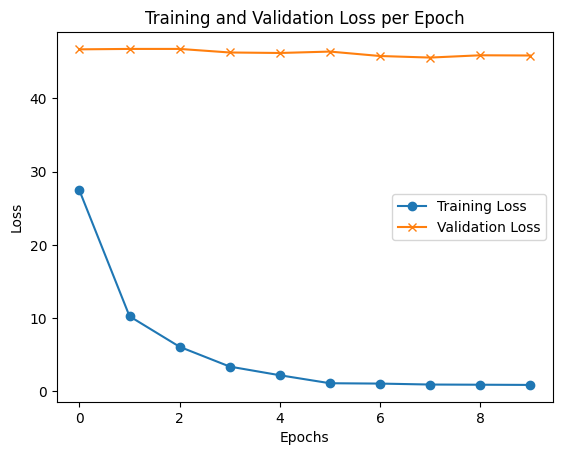

In [28]:
# Extracting training and validation losses
training_losses = hist[0]
validation_losses = hist[1]

if len(training_losses) != len(validation_losses):
    # If the training and validation losses are not the same length, we need to trim the longer list
    min_length = min(len(training_losses), len(validation_losses))
# Number of epochs (should match the trimmed lists)
epochs = epochs

# Extract the actual loss values from the lists
training_losses = [loss[0] for loss in training_losses]
validation_losses = [loss[0] for loss in validation_losses]

# Plotting the training and validation losses
plt.plot(training_losses, label='Training Loss', marker='o')
plt.plot(validation_losses, label='Validation Loss', marker='x')

# Adding labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Show the graph
plt.show()

#### Basic beep indicating training is done

In [29]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)

#### Saving the weights

In [30]:
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [31]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 256, kernel_size=(2, 2), stride=(2, 2))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=256, out_features=256, bias=True)
        (heads): ModuleList(
          (0-1): 2 x AttentionHead(
            (query): Linear(in_features=256, out_features=128, bias=True)
            (key): Linear(in_features=256, out_features=128, bias=True)
            (value): Linear(in_features=256, out_features=128, bias=True)
          )
        )
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
 

## Prediction

- This is the same method used in the validation but it stores predicted data to be visualized 
- Comment and uncomment lines to print different parts like 
- The Microbleed that is shown on the full MRI image 
- The 16x16 patch to see the mask output

In [32]:
def predict(model, image, mask):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(images = image, mask = mask)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [33]:
for i, data in enumerate(val_loader):
    print(data)

(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

0it [00:00, ?it/s]

Case: 305
No bounding boxes found on slice  3
Slice 3 |  [262, 166, 266, 170]
torch.Size([1, 512, 512])
No bounding boxes found on slice  12
Slice 12 |  [110, 298, 116, 304]
torch.Size([1, 512, 512])


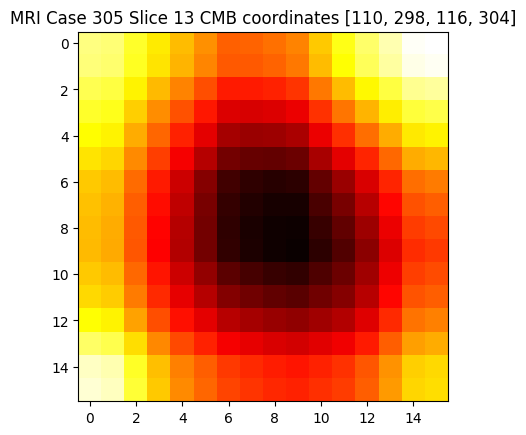

Predicting on Case 305 Slice 13 CMB coordinates [110, 298, 116, 304]


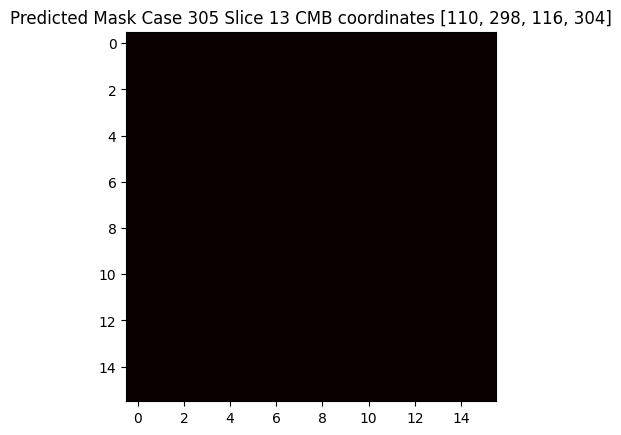

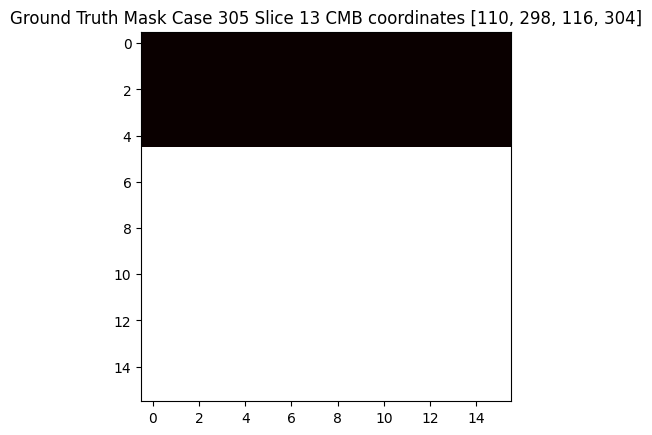

1it [00:00,  1.87it/s]

No bounding boxes found on slice  13
Slice 13 |  [110, 300, 116, 304]
torch.Size([1, 512, 512])
Case: 102
No bounding boxes found on slice  17
Slice 17 |  [246, 316, 255, 325]
torch.Size([1, 512, 512])


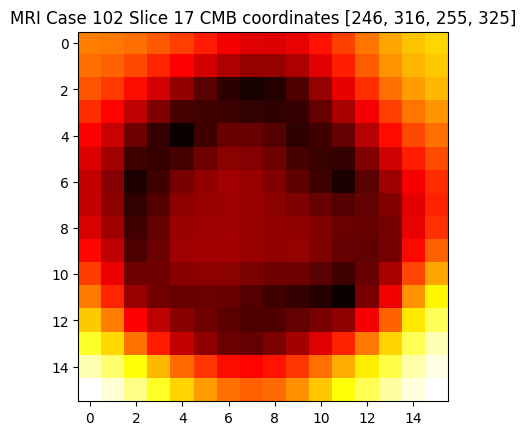

Predicting on Case 102 Slice 17 CMB coordinates [246, 316, 255, 325]


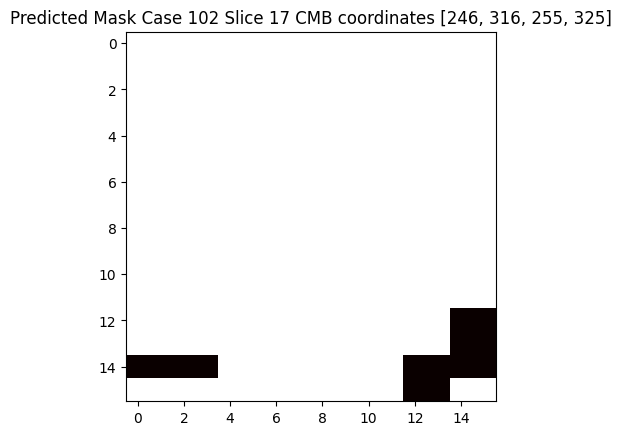

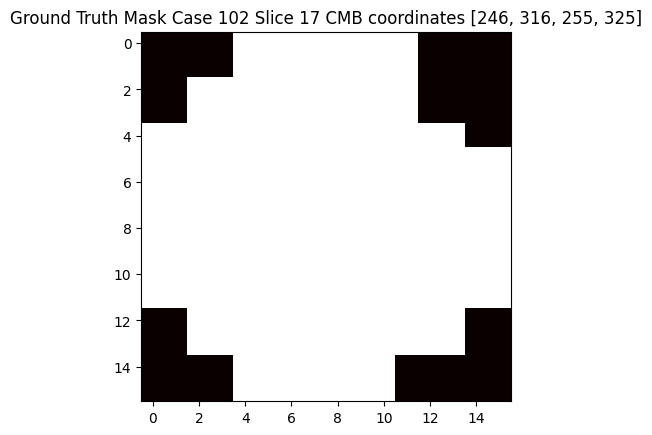

3it [00:02,  1.06s/it]

Case: 210


4it [00:04,  1.34s/it]

Case: 204


5it [00:06,  1.51s/it]

Case: 220


6it [00:08,  1.58s/it]

Case: 230
Case: 319
No bounding boxes found on slice  2
Slice 2 |  [172, 256, 178, 264]
torch.Size([1, 512, 512])


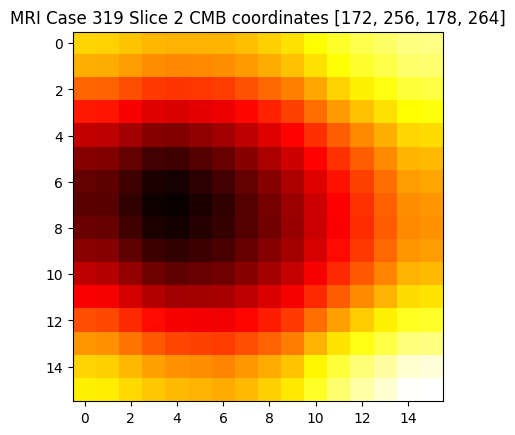

Predicting on Case 319 Slice 2 CMB coordinates [172, 256, 178, 264]


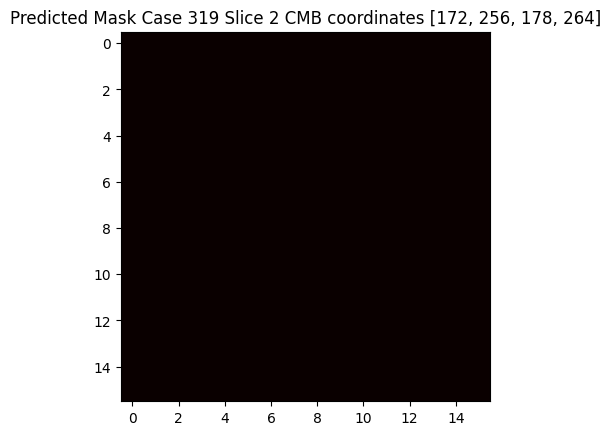

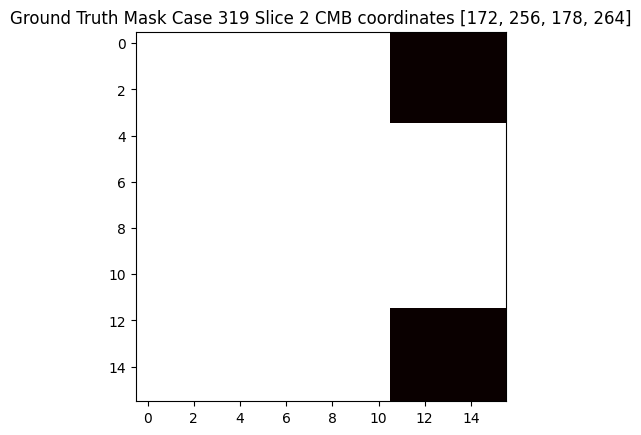

8it [00:08,  1.12it/s]

Case: 310
No bounding boxes found on slice  31
Slice 31 |  [336, 210, 340, 214]
torch.Size([1, 512, 512])
Case: 229
No bounding boxes found on slice  126
Slice 126 |  [166, 338, 169, 341]
torch.Size([1, 512, 512])


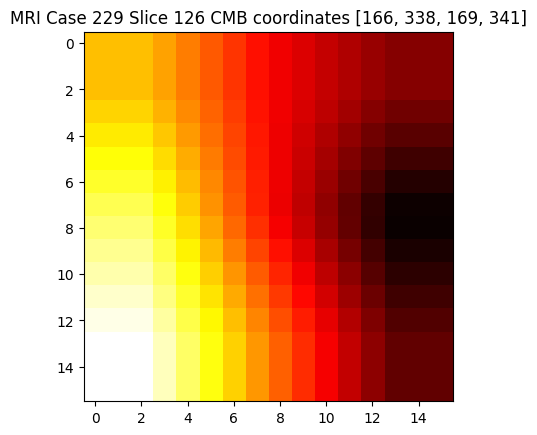

Predicting on Case 229 Slice 126 CMB coordinates [166, 338, 169, 341]


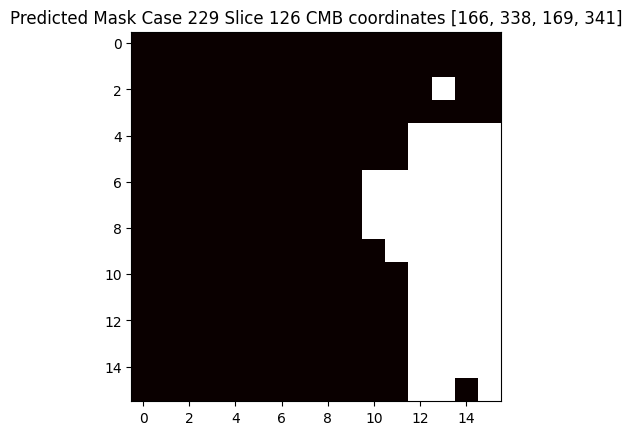

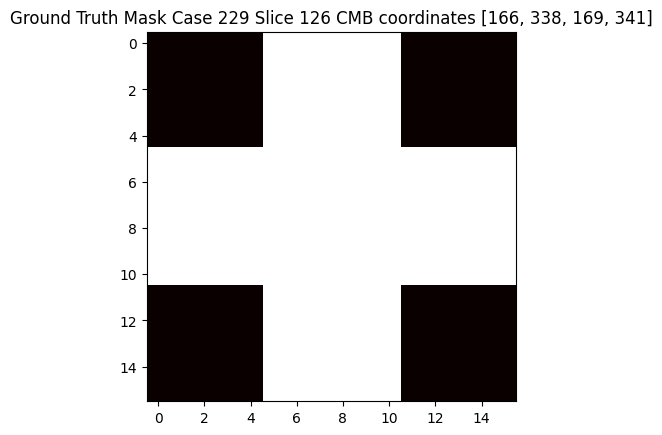

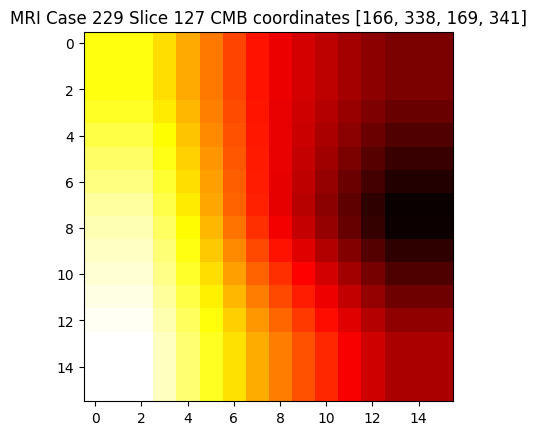

Predicting on Case 229 Slice 127 CMB coordinates [166, 338, 169, 341]


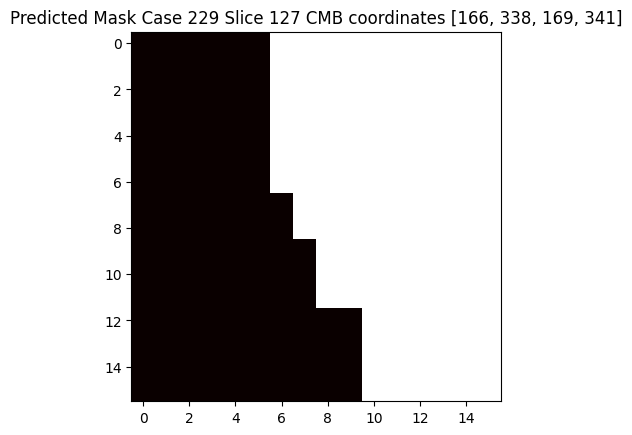

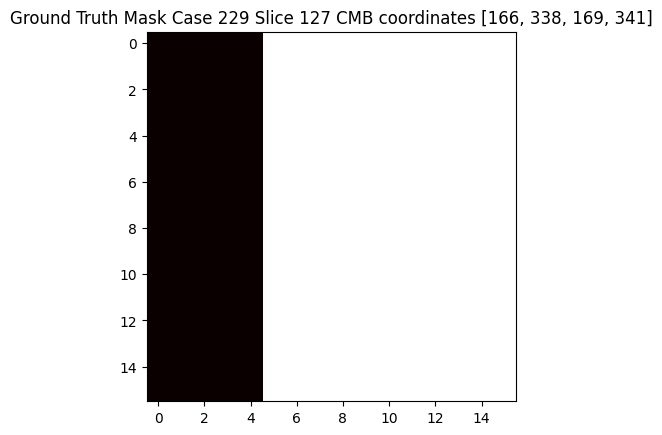

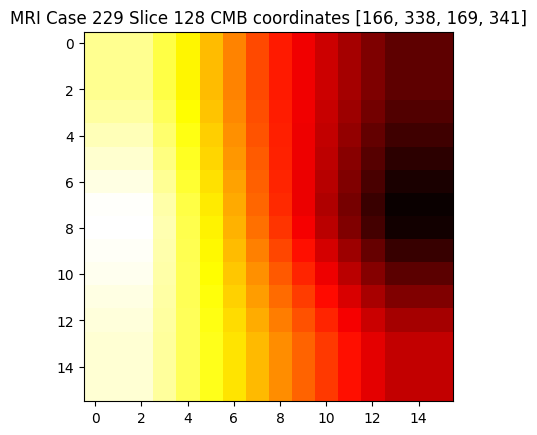

Predicting on Case 229 Slice 128 CMB coordinates [166, 338, 169, 341]


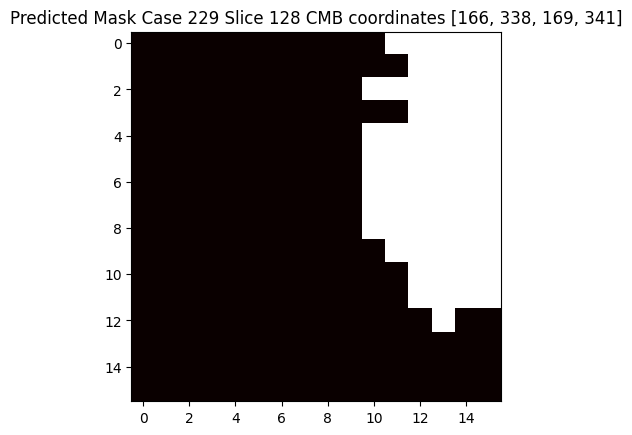

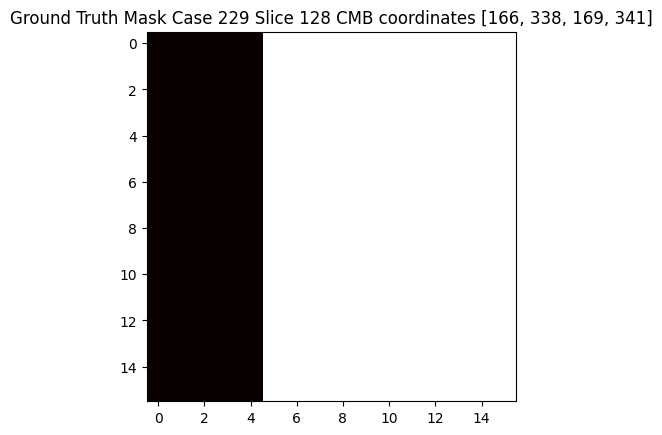

No bounding boxes found on slice  127
Slice 127 |  [167, 338, 169, 341]
torch.Size([1, 512, 512])


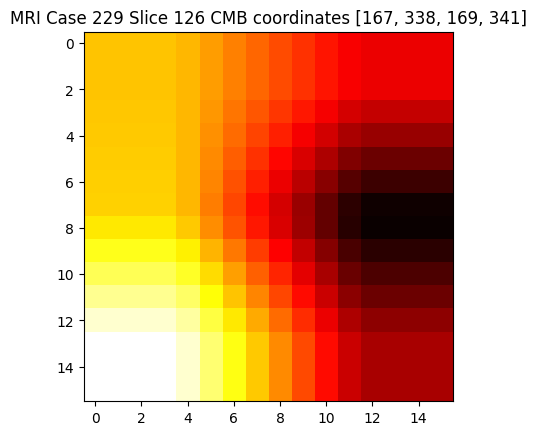

Predicting on Case 229 Slice 126 CMB coordinates [167, 338, 169, 341]


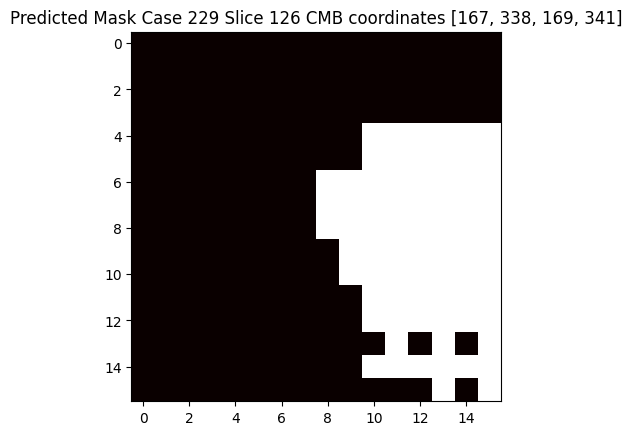

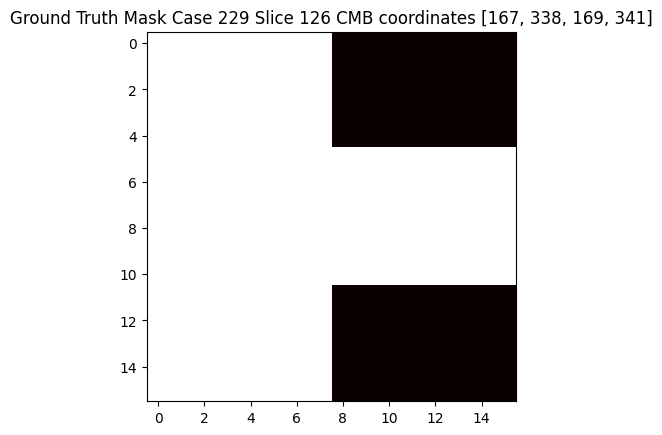

No bounding boxes found on slice  128
Slice 128 |  [167, 338, 169, 341]
torch.Size([1, 512, 512])


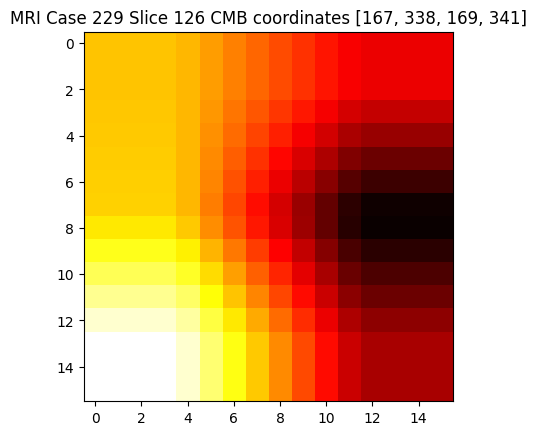

Predicting on Case 229 Slice 126 CMB coordinates [167, 338, 169, 341]


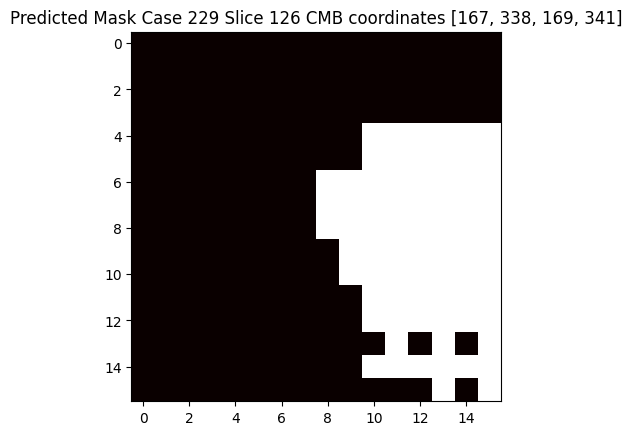

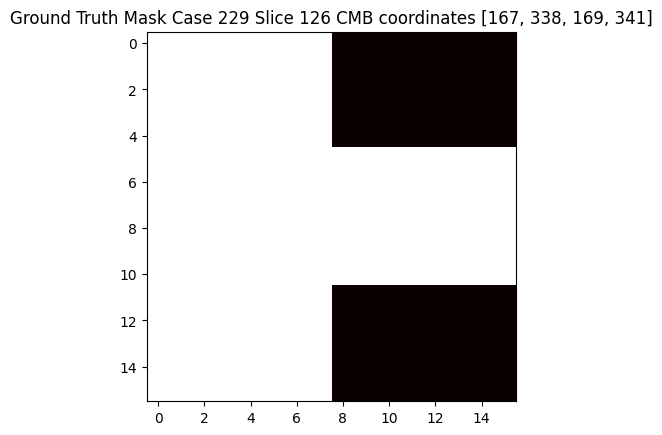

10it [00:14,  1.86s/it]

Case: 205
Case: 304
No bounding boxes found on slice  20
Slice 20 |  [214, 302, 220, 308]
torch.Size([1, 512, 512])


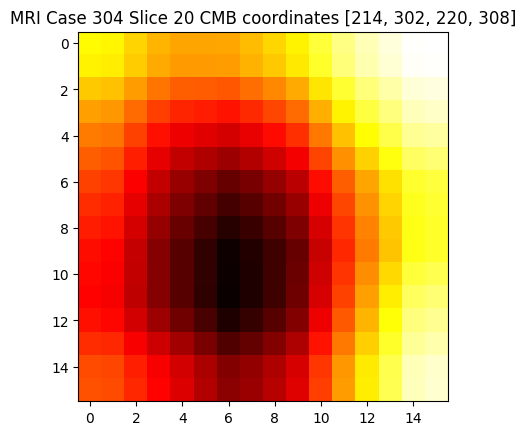

Predicting on Case 304 Slice 20 CMB coordinates [214, 302, 220, 308]


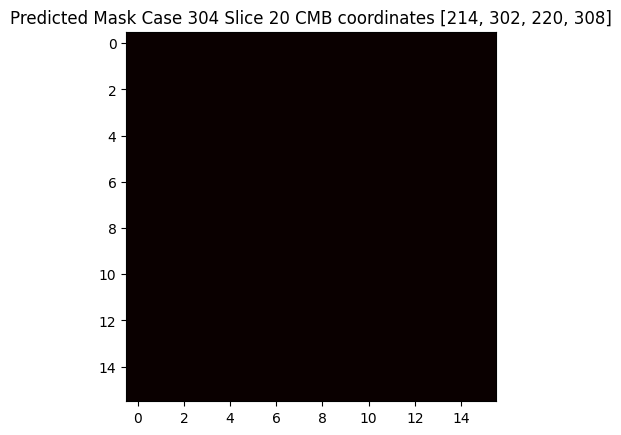

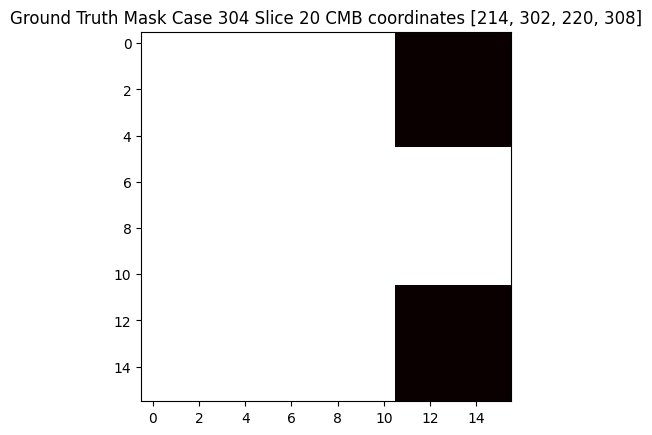

11it [00:15,  1.62s/it]

Case: 232
No bounding boxes found on slice  108
Slice 108 |  [340, 227, 342, 229]
torch.Size([1, 512, 512])


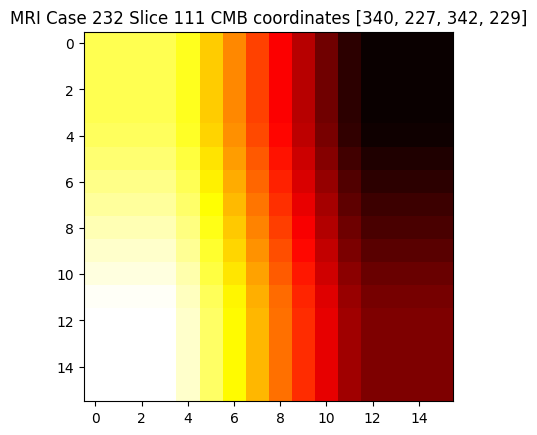

Predicting on Case 232 Slice 111 CMB coordinates [340, 227, 342, 229]


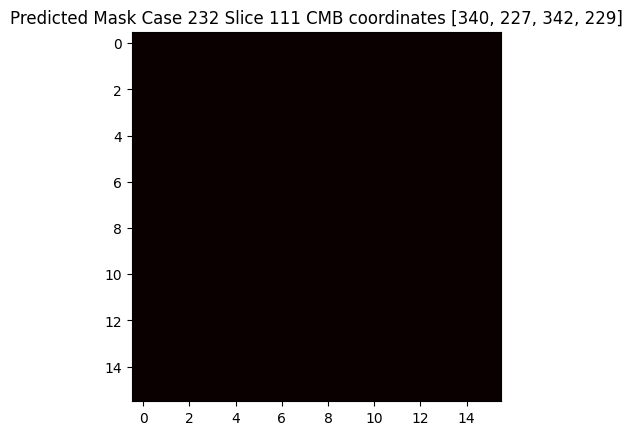

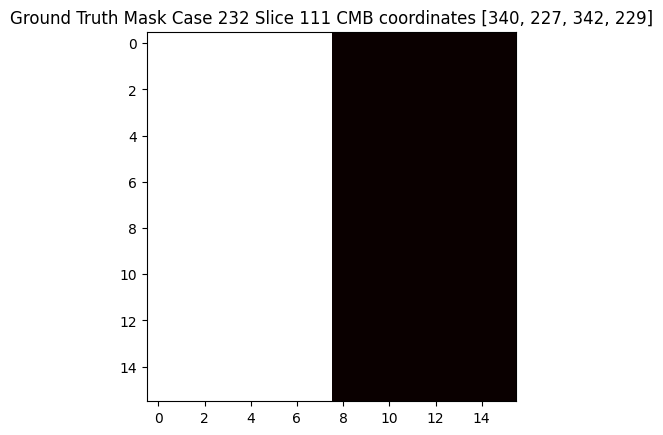

No bounding boxes found on slice  109
Slice 109 |  [339, 226, 342, 230]
torch.Size([1, 512, 512])


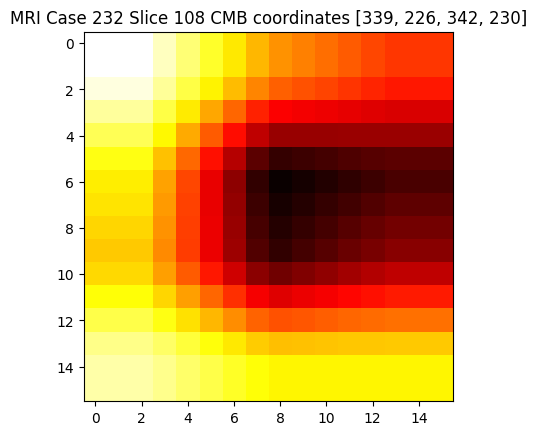

Predicting on Case 232 Slice 108 CMB coordinates [339, 226, 342, 230]


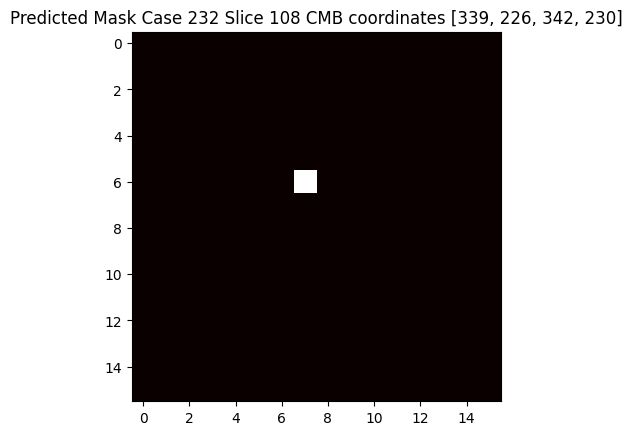

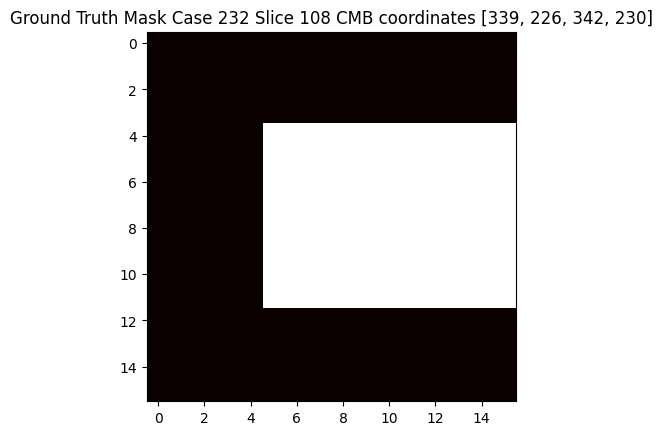

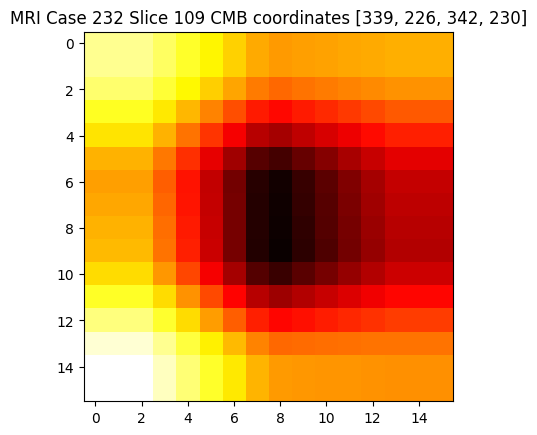

Predicting on Case 232 Slice 109 CMB coordinates [339, 226, 342, 230]


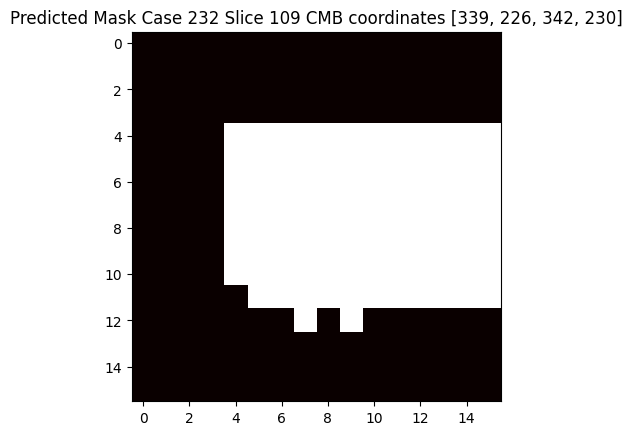

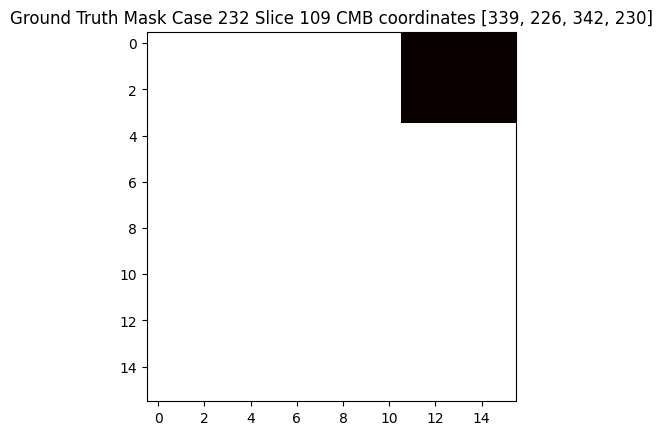

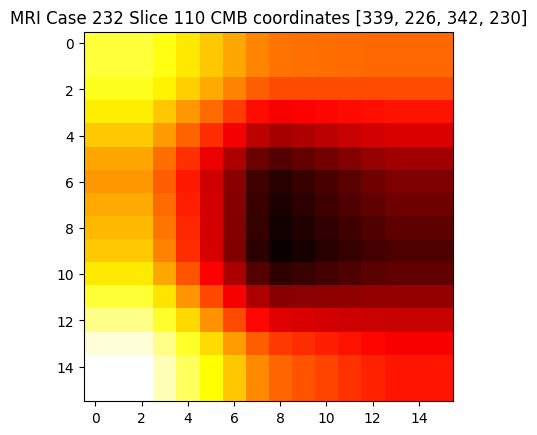

Predicting on Case 232 Slice 110 CMB coordinates [339, 226, 342, 230]


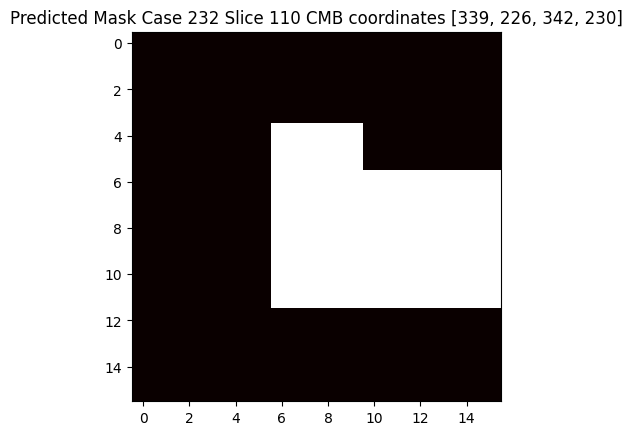

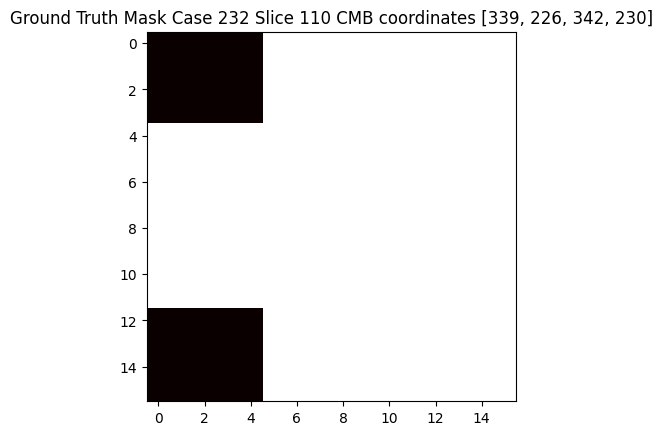

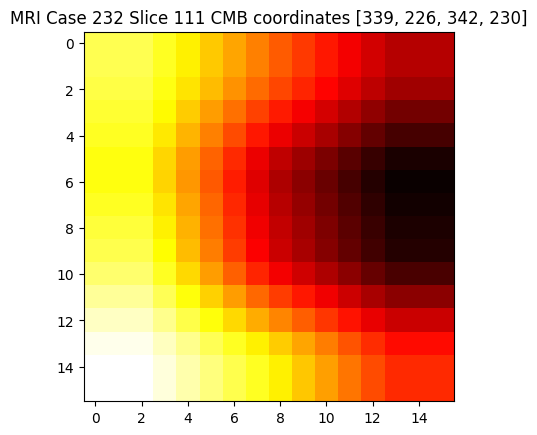

Predicting on Case 232 Slice 111 CMB coordinates [339, 226, 342, 230]


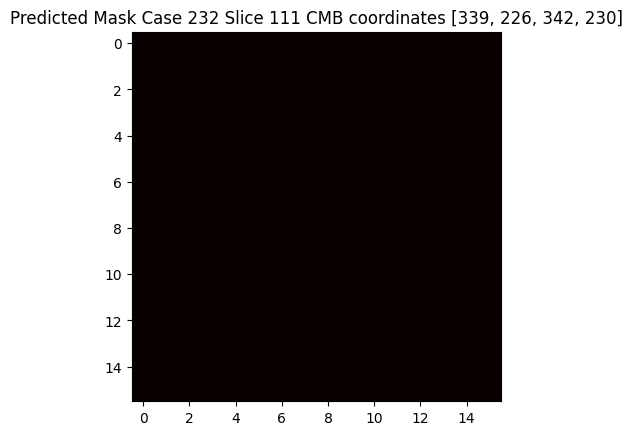

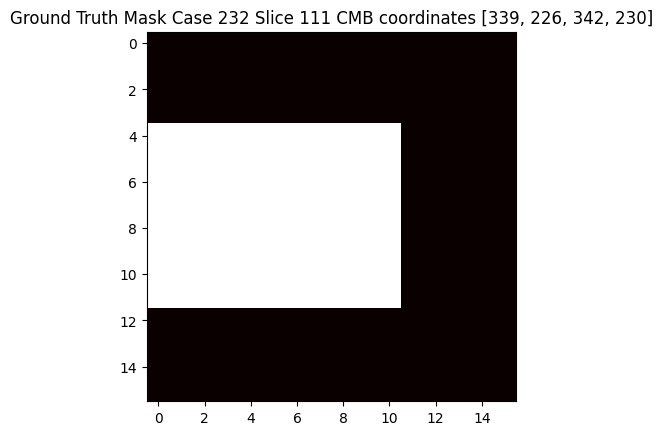

No bounding boxes found on slice  110
Slice 110 |  [339, 226, 342, 230]
torch.Size([1, 512, 512])


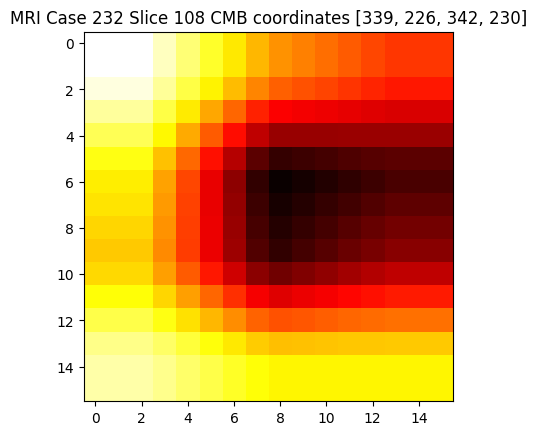

Predicting on Case 232 Slice 108 CMB coordinates [339, 226, 342, 230]


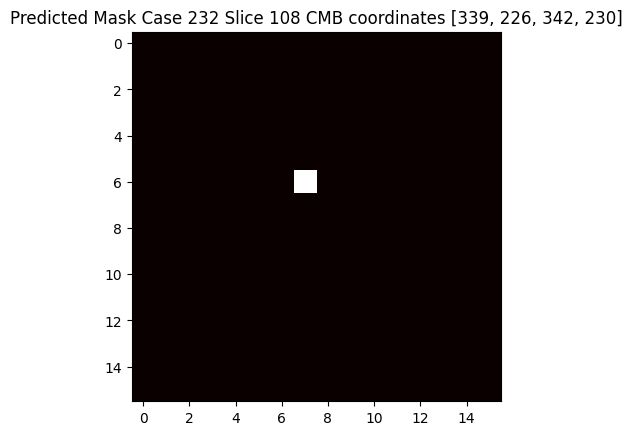

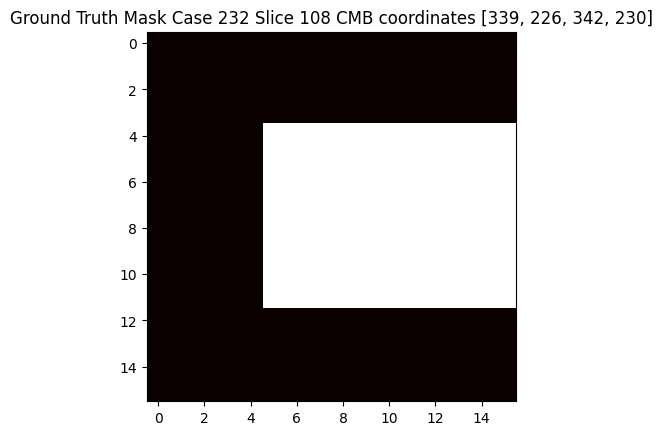

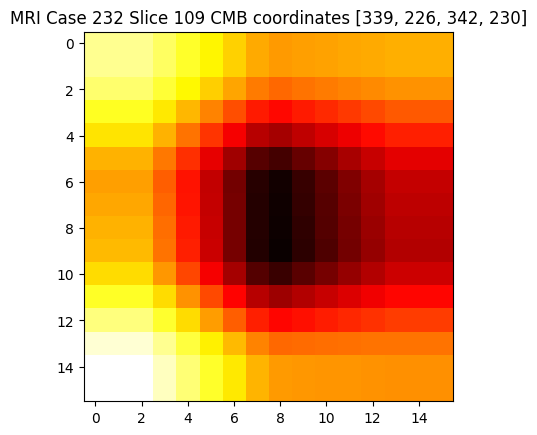

Predicting on Case 232 Slice 109 CMB coordinates [339, 226, 342, 230]


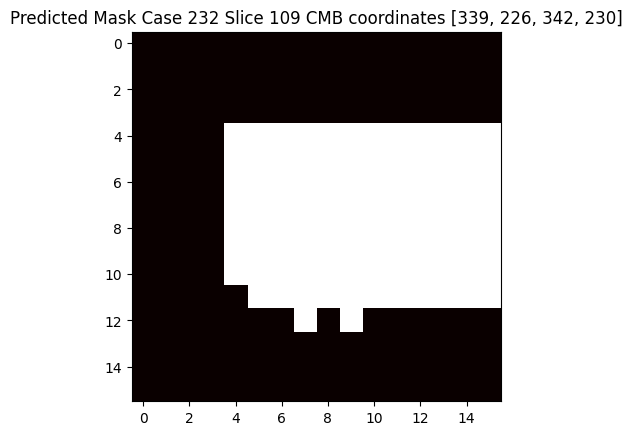

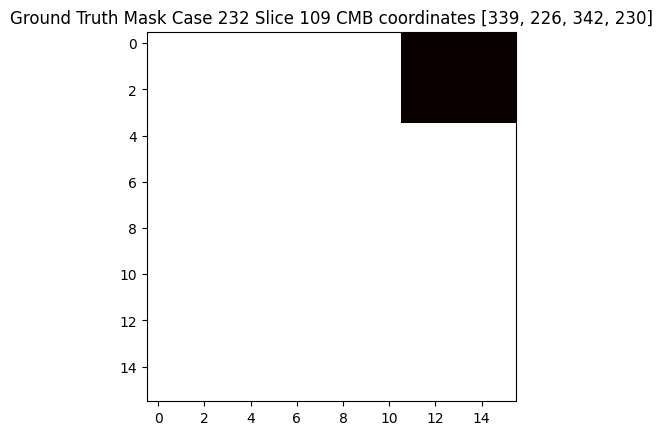

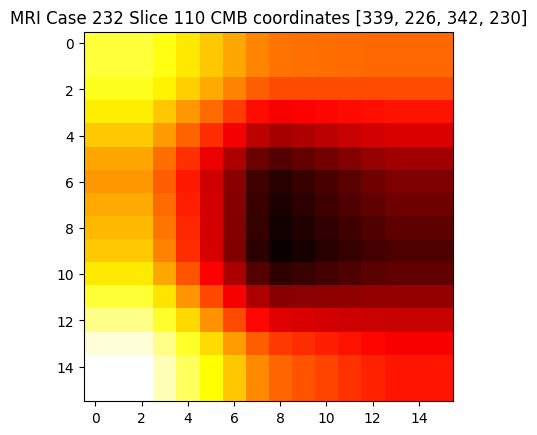

Predicting on Case 232 Slice 110 CMB coordinates [339, 226, 342, 230]


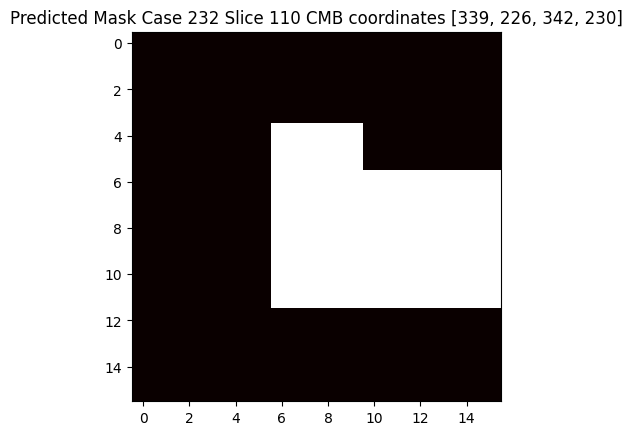

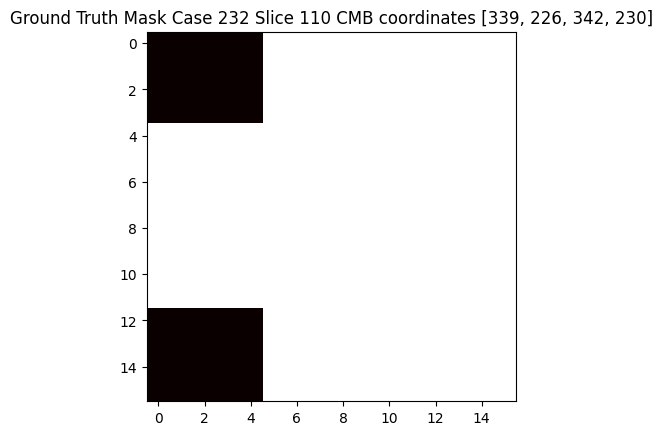

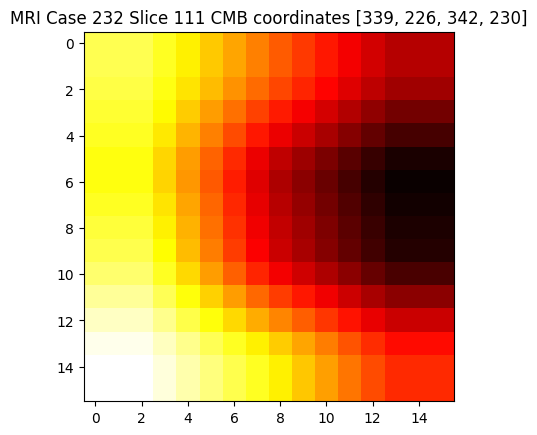

Predicting on Case 232 Slice 111 CMB coordinates [339, 226, 342, 230]


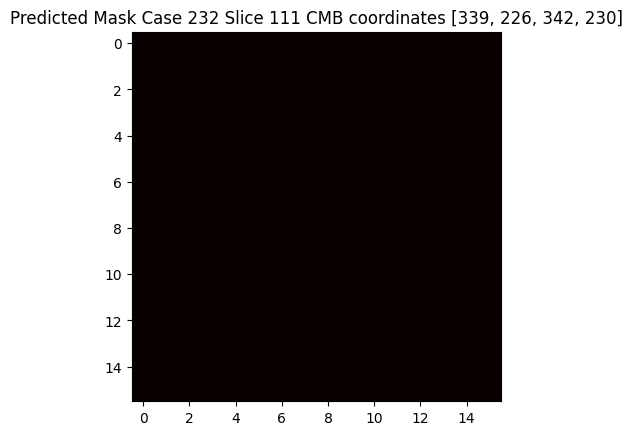

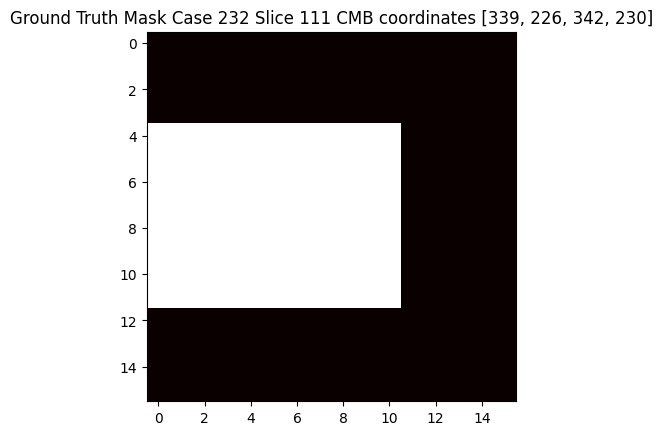

No bounding boxes found on slice  111
Slice 111 |  [339, 227, 341, 229]
torch.Size([1, 512, 512])


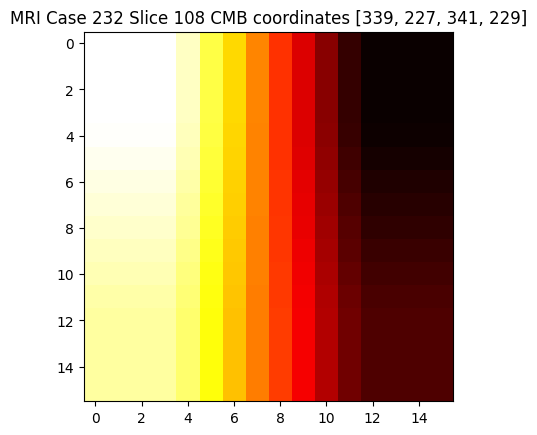

Predicting on Case 232 Slice 108 CMB coordinates [339, 227, 341, 229]


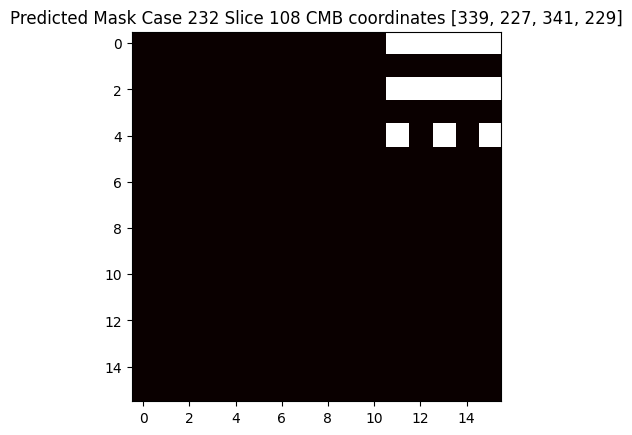

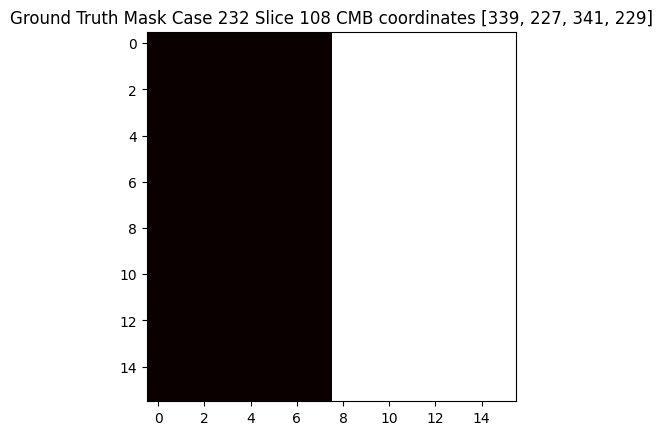

12it [00:22,  3.19s/it]

Case: 302
No bounding boxes found on slice  22
Slice 22 |  [368, 188, 372, 194]
torch.Size([1, 512, 512])


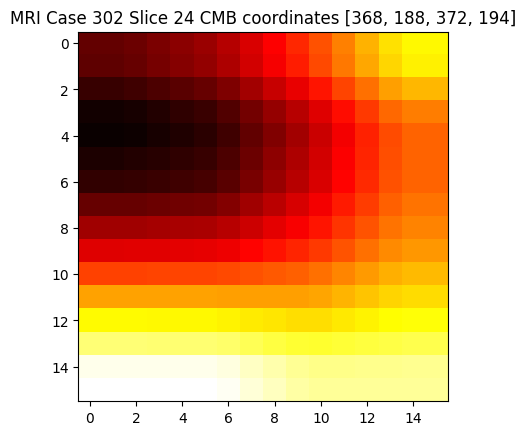

Predicting on Case 302 Slice 24 CMB coordinates [368, 188, 372, 194]


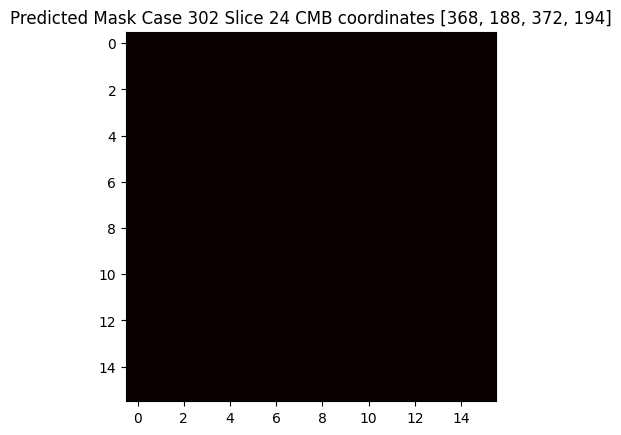

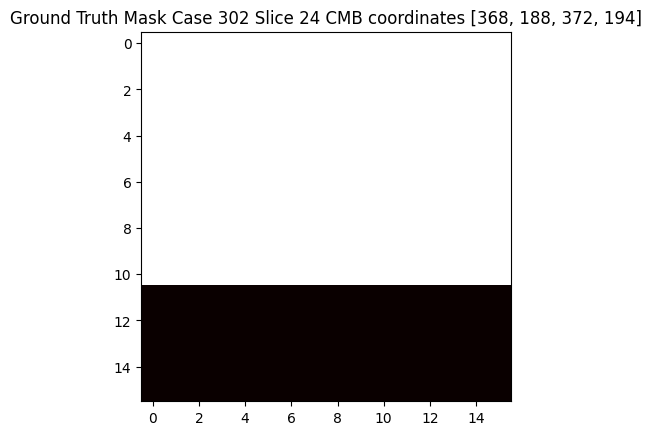

No bounding boxes found on slice  23
Slice 23 |  [366, 186, 374, 194]
torch.Size([1, 512, 512])


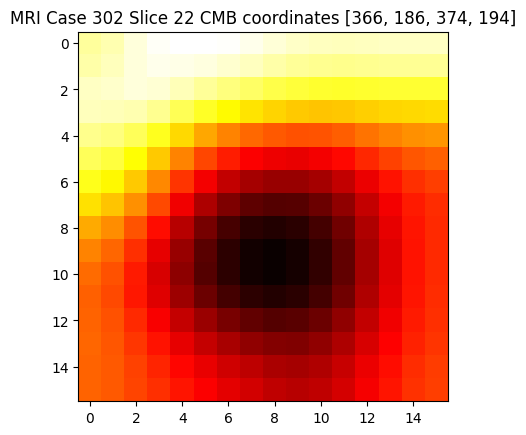

Predicting on Case 302 Slice 22 CMB coordinates [366, 186, 374, 194]


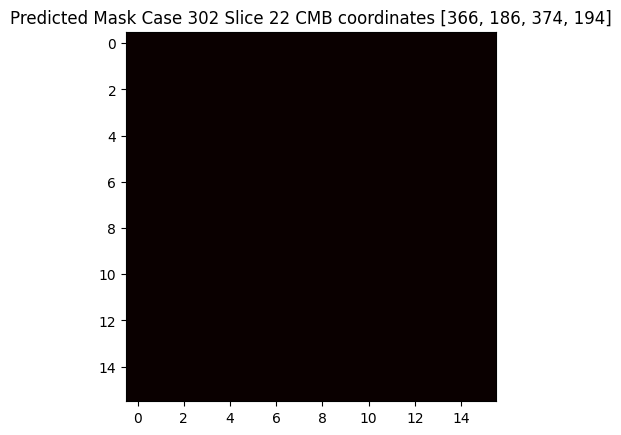

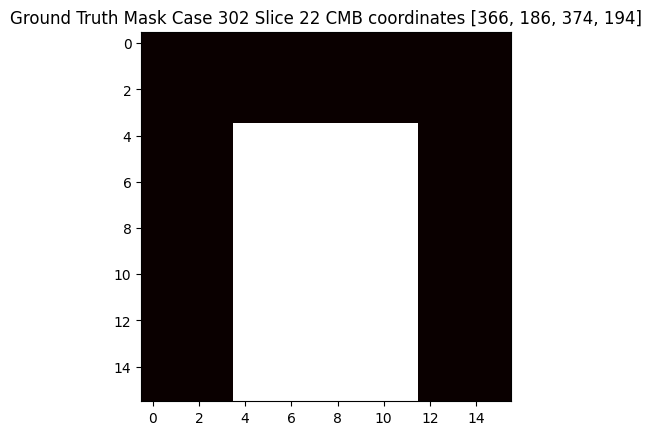

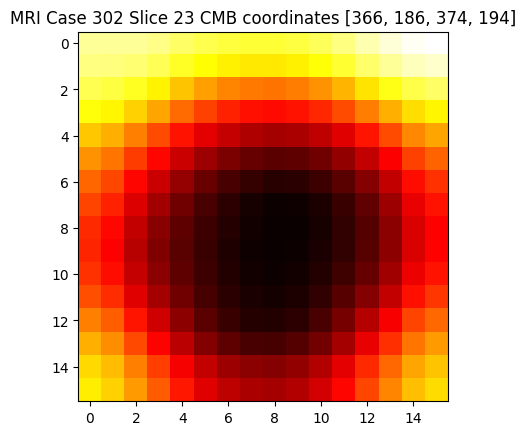

Predicting on Case 302 Slice 23 CMB coordinates [366, 186, 374, 194]


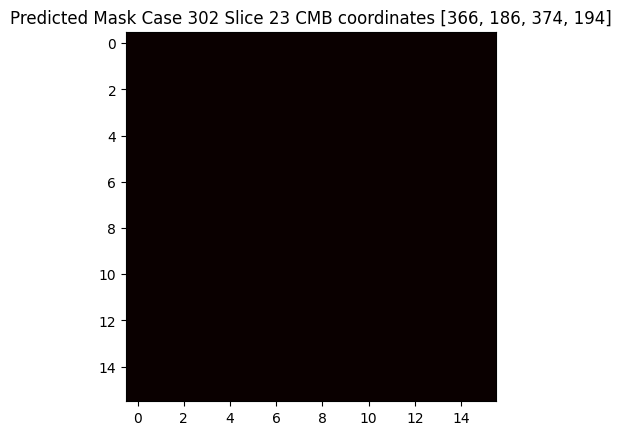

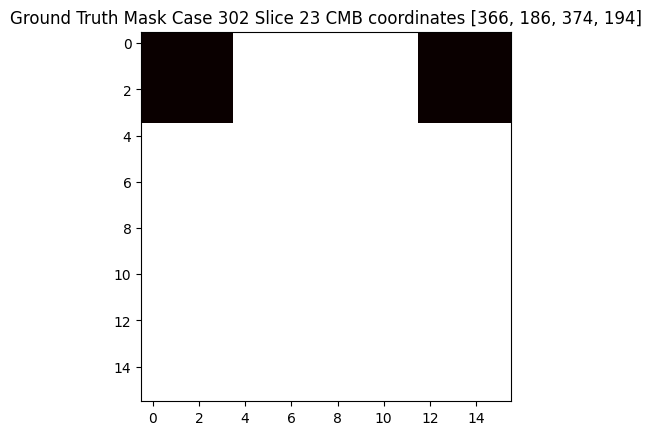

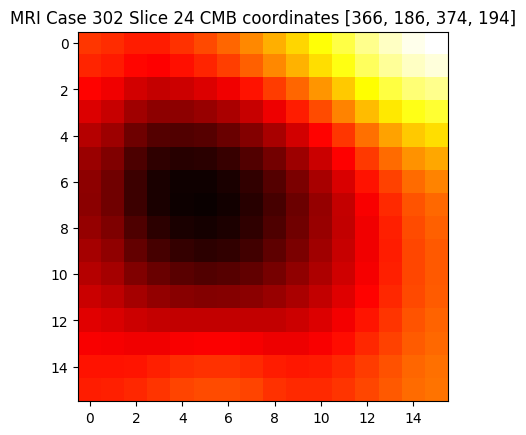

Predicting on Case 302 Slice 24 CMB coordinates [366, 186, 374, 194]


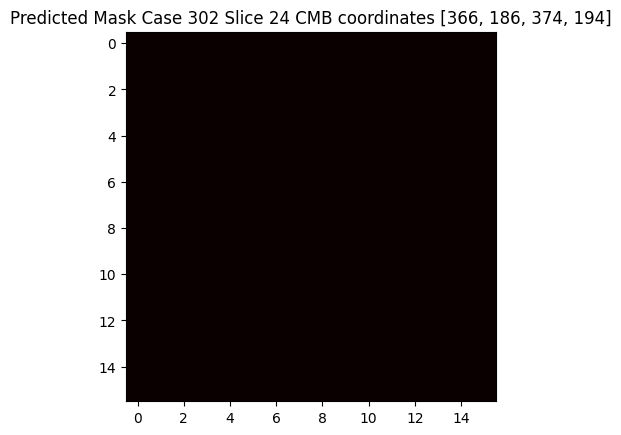

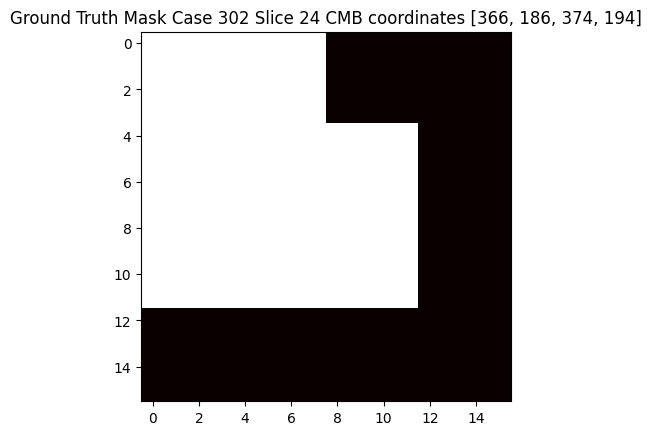

No bounding boxes found on slice  24
Slice 24 |  [366, 186, 372, 192]
torch.Size([1, 512, 512])


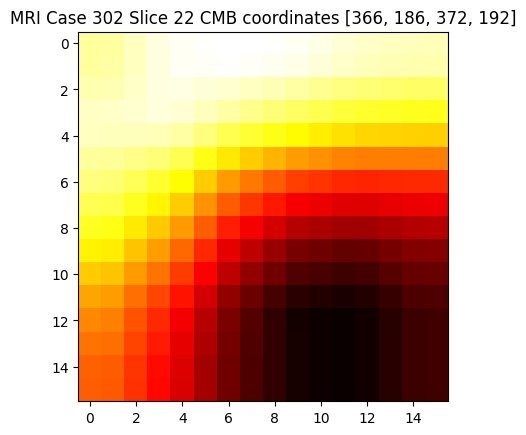

Predicting on Case 302 Slice 22 CMB coordinates [366, 186, 372, 192]


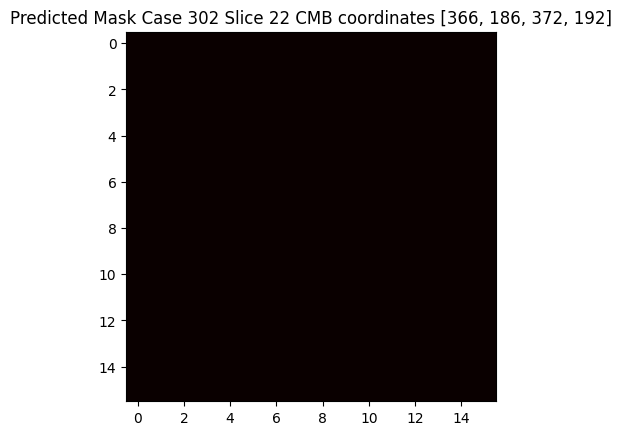

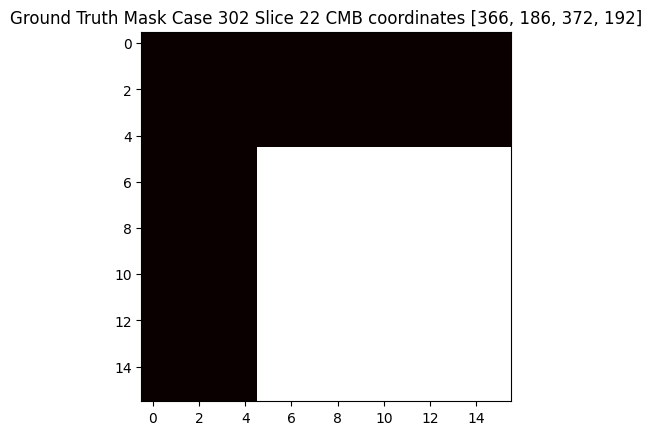

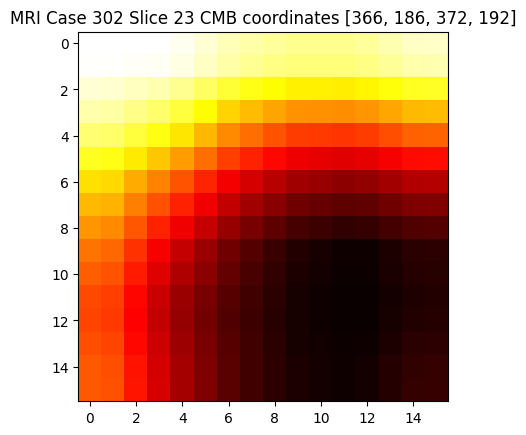

Predicting on Case 302 Slice 23 CMB coordinates [366, 186, 372, 192]


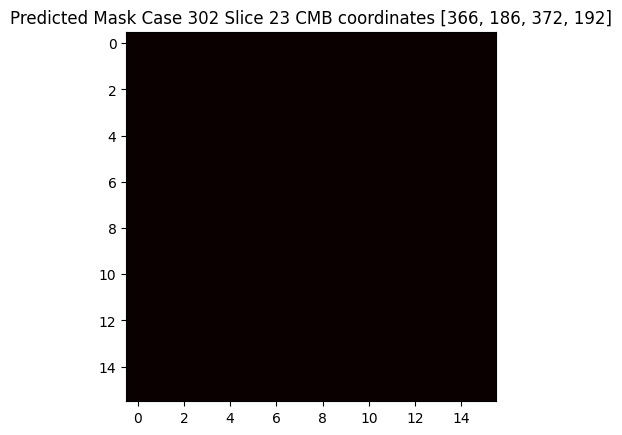

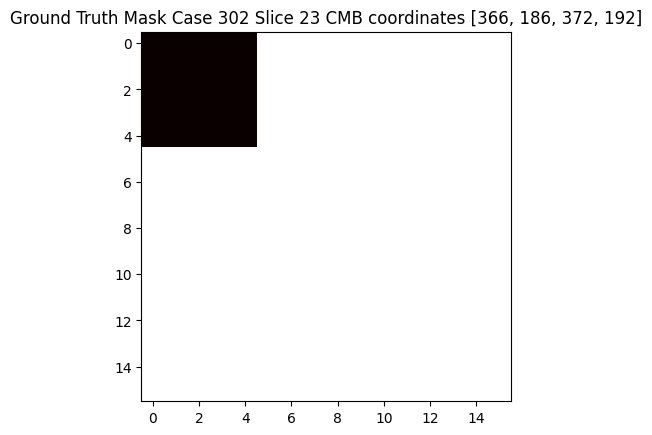

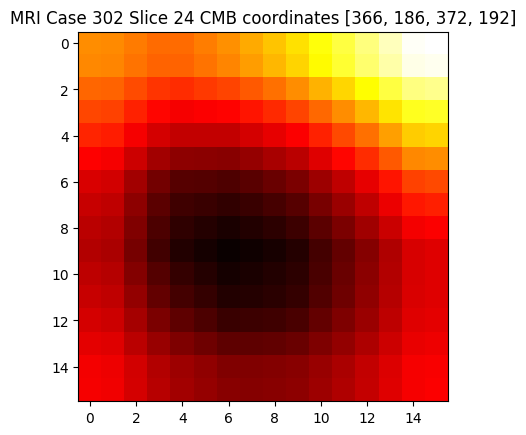

Predicting on Case 302 Slice 24 CMB coordinates [366, 186, 372, 192]


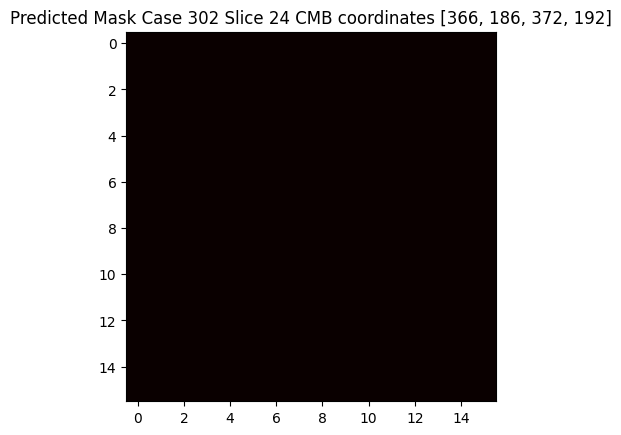

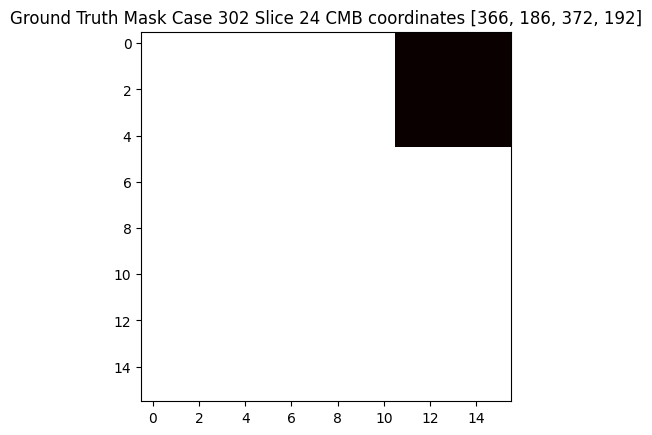

13it [00:25,  3.10s/it]

Case: 213
No bounding boxes found on slice  91
Slice 91 |  [153, 167, 155, 170]
torch.Size([1, 512, 512])


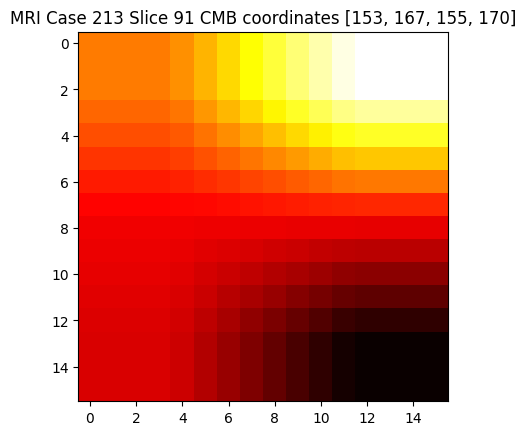

Predicting on Case 213 Slice 91 CMB coordinates [153, 167, 155, 170]


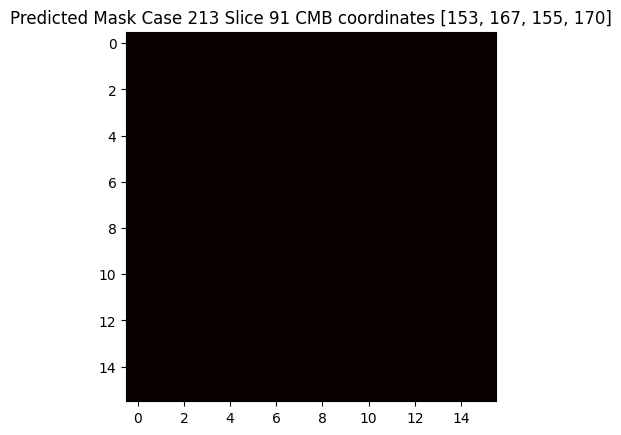

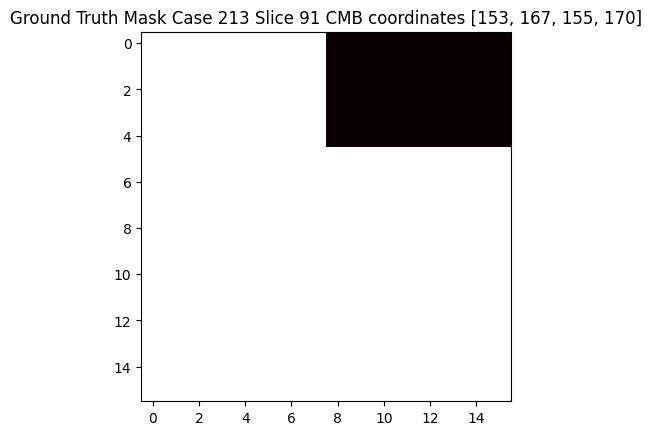

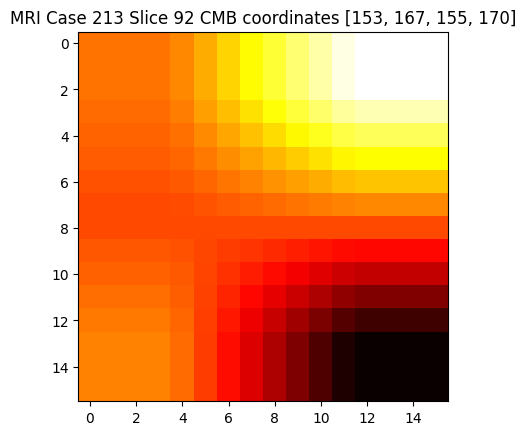

Predicting on Case 213 Slice 92 CMB coordinates [153, 167, 155, 170]


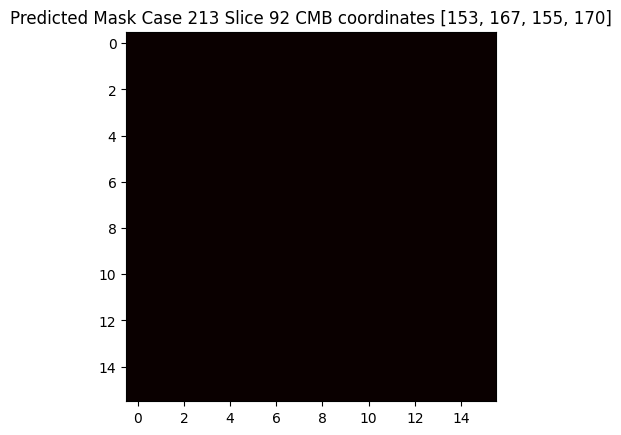

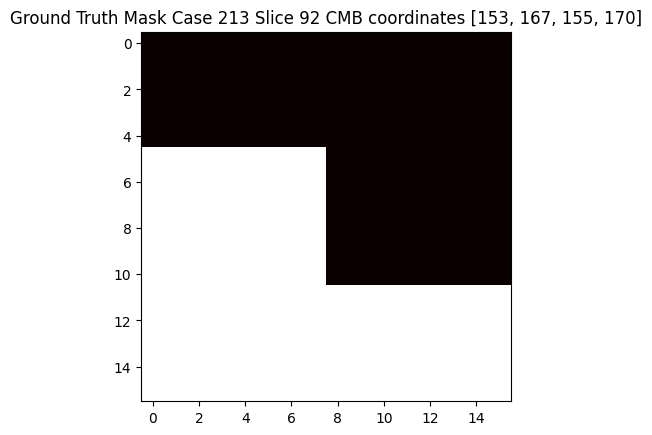

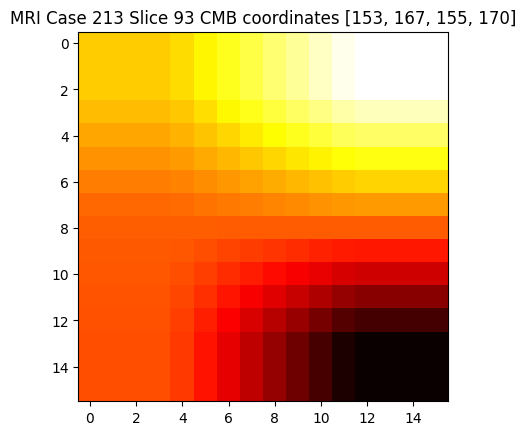

Predicting on Case 213 Slice 93 CMB coordinates [153, 167, 155, 170]


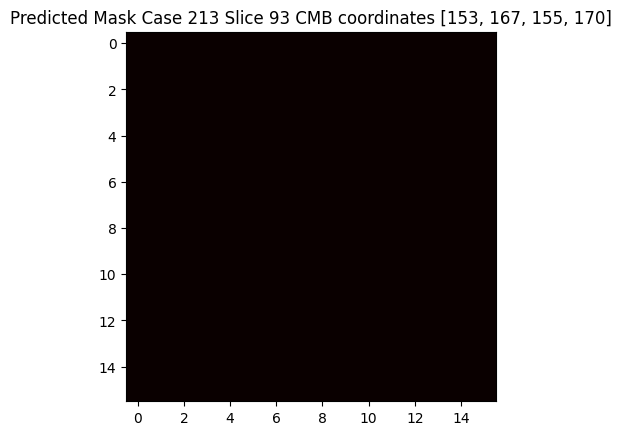

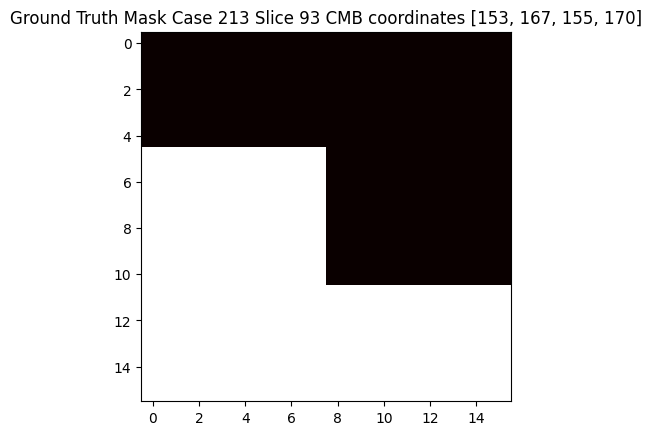

No bounding boxes found on slice  92
Slice 92 |  [153, 168, 155, 171]
torch.Size([1, 512, 512])


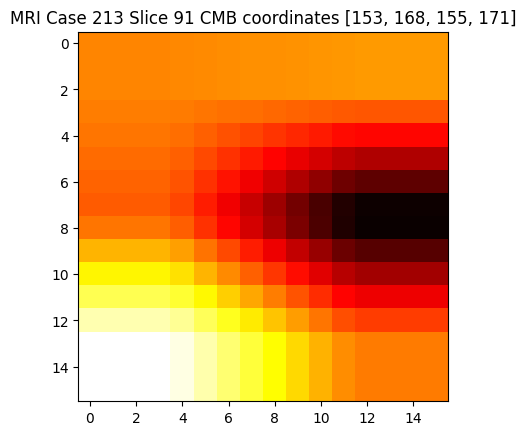

Predicting on Case 213 Slice 91 CMB coordinates [153, 168, 155, 171]


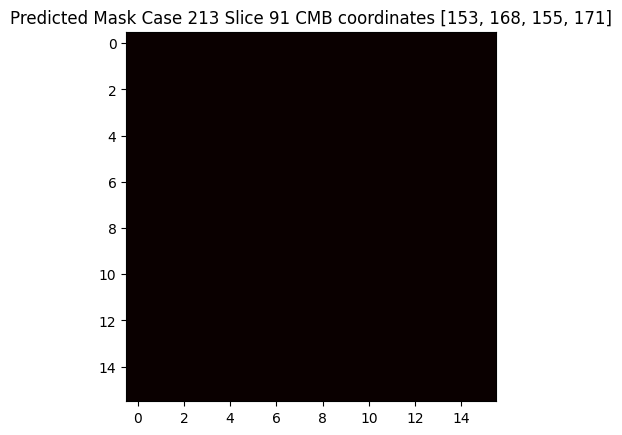

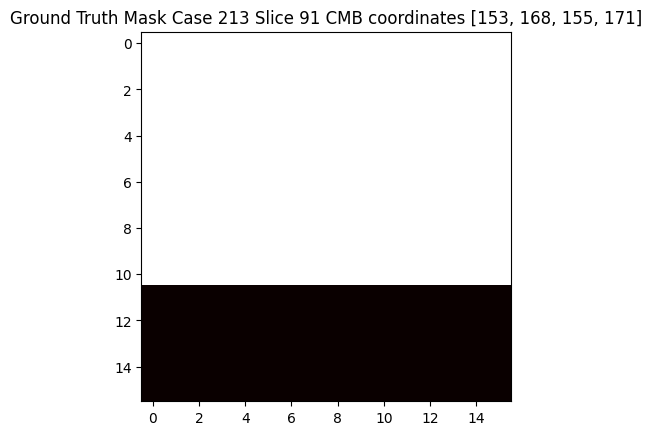

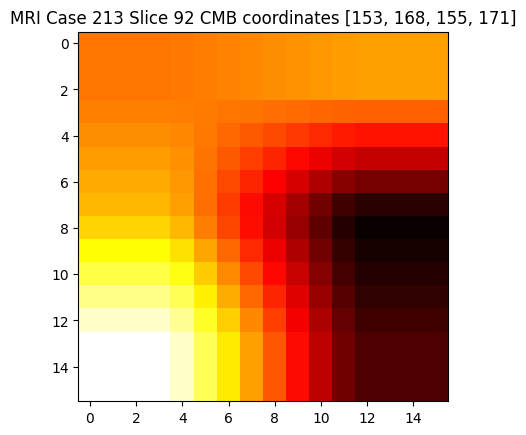

Predicting on Case 213 Slice 92 CMB coordinates [153, 168, 155, 171]


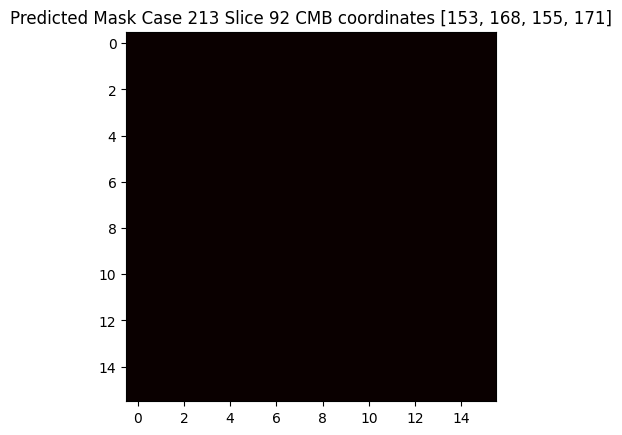

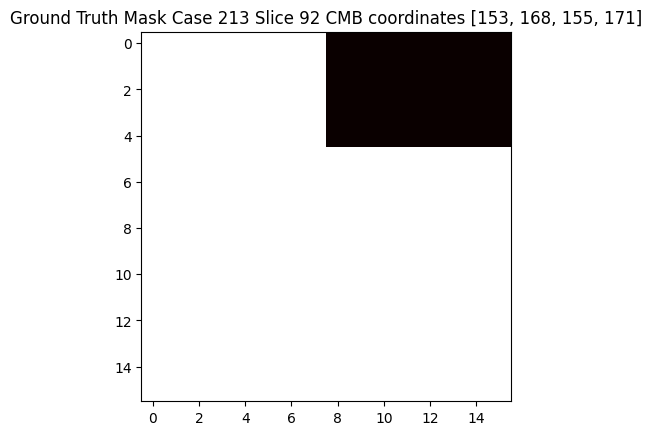

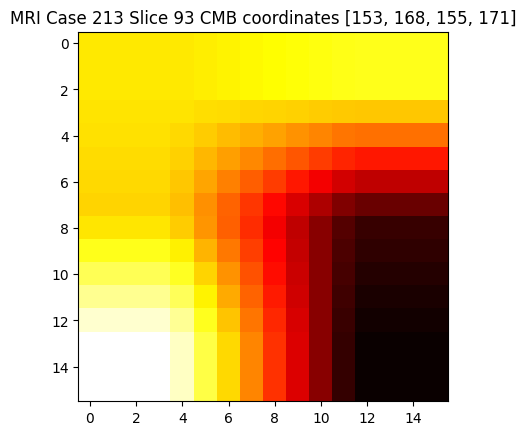

Predicting on Case 213 Slice 93 CMB coordinates [153, 168, 155, 171]


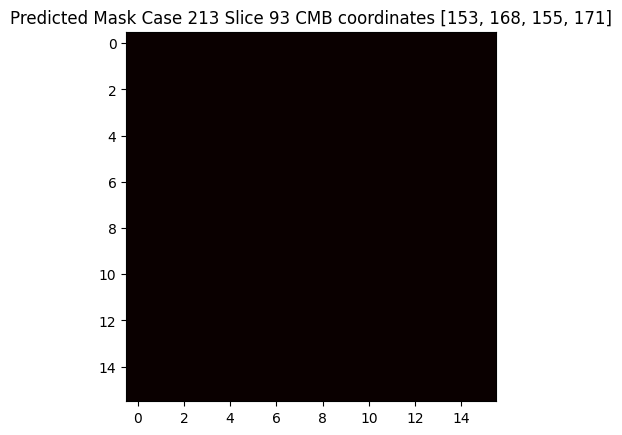

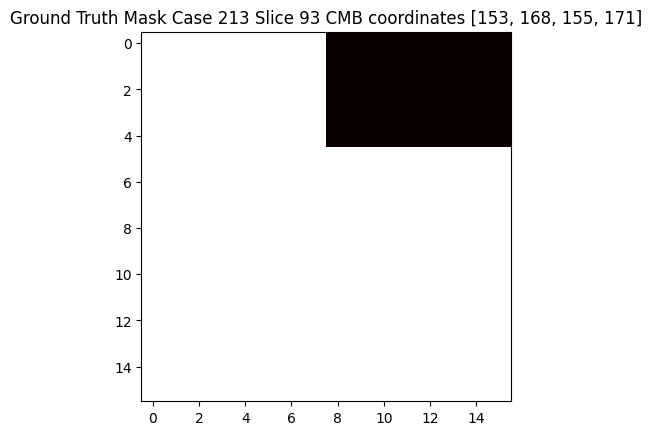

No bounding boxes found on slice  93
Slice 93 |  [153, 168, 156, 172]
torch.Size([1, 512, 512])


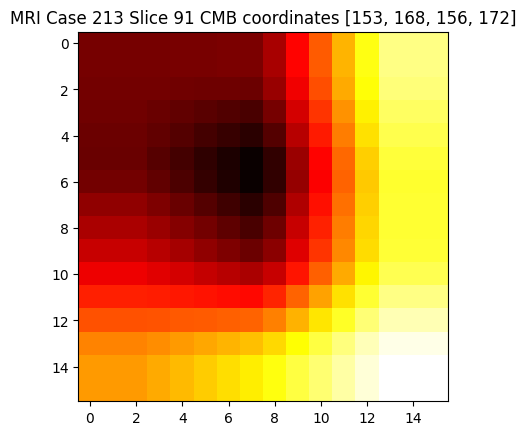

Predicting on Case 213 Slice 91 CMB coordinates [153, 168, 156, 172]


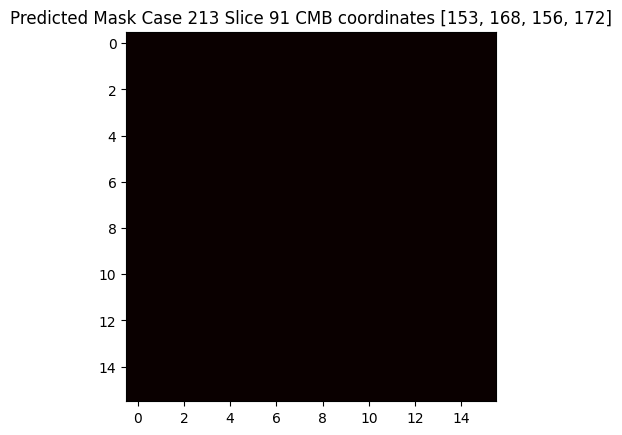

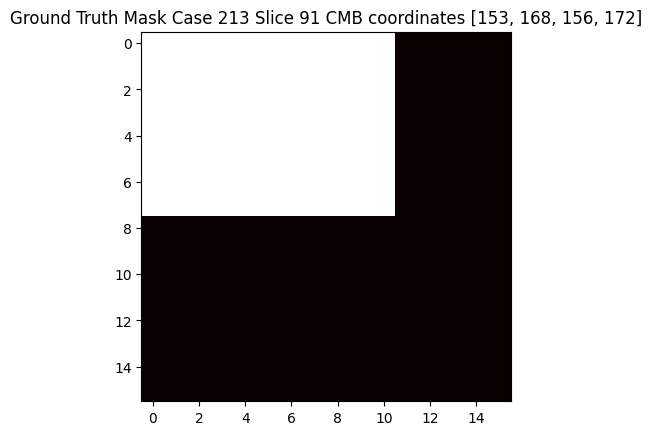

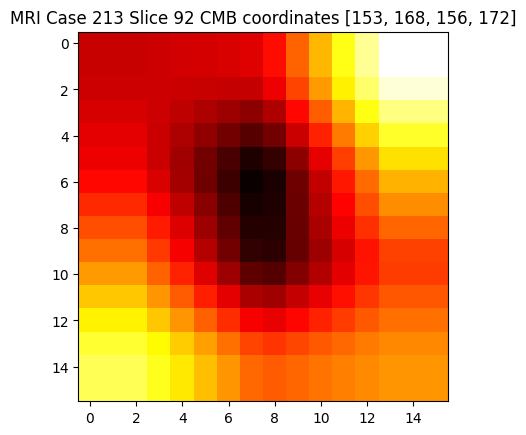

Predicting on Case 213 Slice 92 CMB coordinates [153, 168, 156, 172]


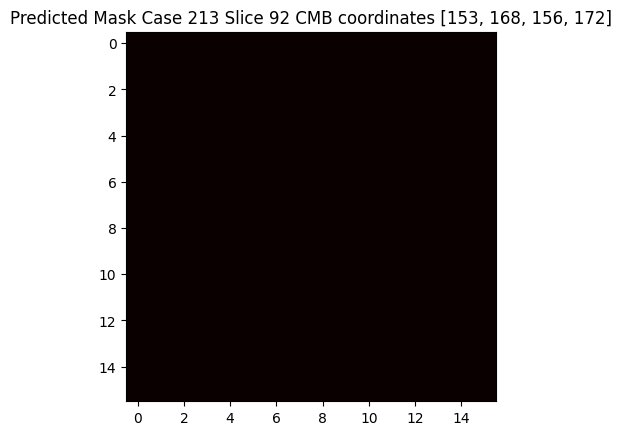

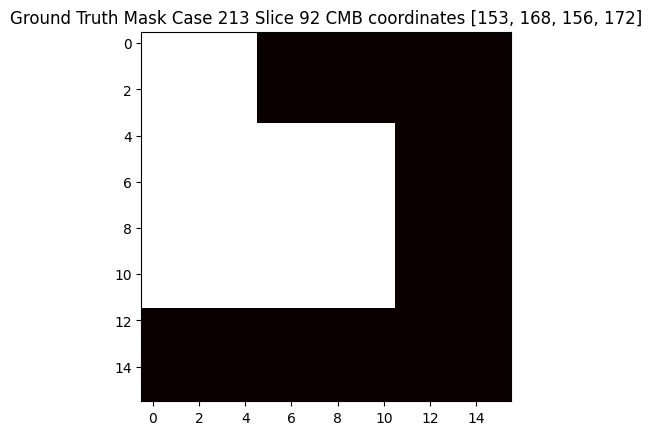

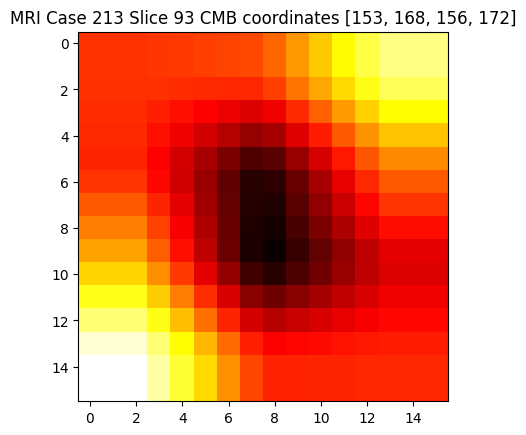

Predicting on Case 213 Slice 93 CMB coordinates [153, 168, 156, 172]


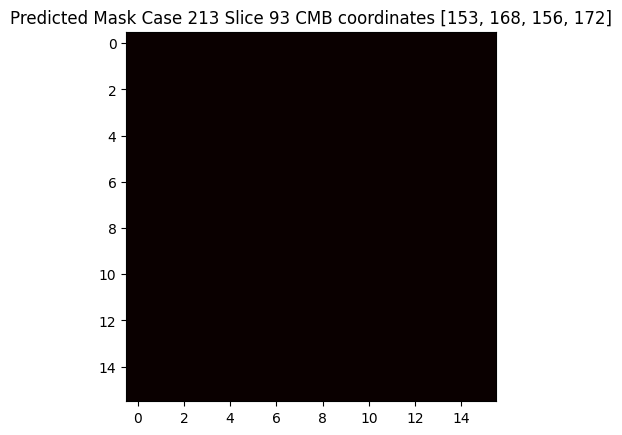

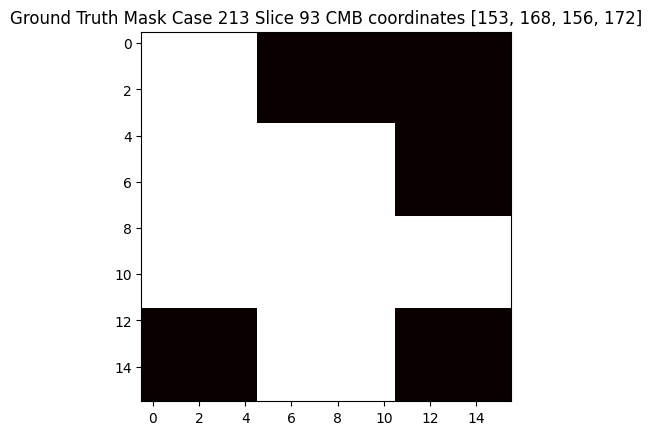

15it [00:30,  2.04s/it]

Case: 321
No bounding boxes found on slice  18
Slice 18 |  [226, 198, 230, 202]
torch.Size([1, 512, 512])
No bounding boxes found on slice  19
Slice 19 |  [282, 230, 286, 234]
torch.Size([1, 512, 512])


In [34]:
val_loss = 0.0
length = len(val_loader)
case = 0 
predictions = []
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(val_loader, 0)):
        num_slices = len(val_batch[1])#Number of slces
        one_case = []#This is where we store every slice of the case 
        case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
        one_case.append(case_number)
        slice_list = []

        # slices_images = [] #This is where we store the images of the slices
        # slices_predictions = [] #This is where we store the predictions of the slices
        # slices_true_labels = [] #This is where we store the true labels of the slices

        print(f'Case: {case_number}')
        if num_slices != len(val_batch[0]):
            print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
            break
        for j in range(num_slices):
            prediction_data = []#This is where we store the data of the slice predictions that will be appended to the slices_predictions list
            slice_data = []
            bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
            cropped_images = []
            cropped_labels = []
            coordinates = []
            if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                print('No bounding boxes found on slice ', j)
                
                for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                    print(f"Slice {j} | ", bbox)
                    print(val_batch[0][j][0].shape)
                    cropped_images.append(
                        dataset.get_cropped_locations(
                            img = val_batch[0], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    cropped_labels.append(
                        dataset.get_cropped_locations(
                            img = val_batch[1], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    coordinates.append(bbox)
                if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                    print('Not equal cropped images and labels')
                    break
                # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                # print('Cropped Images length:', len(cropped_images))
                # print('Cropped Labels length:', len(cropped_labels))
                # print('Cropped Images number of slices:', len(cropped_images[0][0][0]))
                # print('Cropped Labels number of slices:', len(cropped_labels[0][0]))
                for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                    for l, cmb_slice in enumerate(cmb):
                        if torch.unique(cmb_slice).numel() > 1:
                            one_cmb = []
                            # print('Predicting CMB with coordinates: ', coordinates[k])
                            # print(cmb_slice.shape)
                            # print(cropped_images[0][0][0][l].shape)
                            
                            # Enable ths method to visually see what is feeded on the model
                            print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                            labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                            # print("Feeded inputs shape: ",inputs.shape)
                            # print("Feeded mask shape: ",labels.shape)
                            predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float())
                            # print("Output shape: ",predicted_mask.shape)

                            one_cmb.append(predicted_mask[0])
                            one_cmb.append(cmb_slice)
                            one_cmb.append(coordinates[k])
                            prediction_data.append(one_cmb)
                            print_image(predicted_mask[0], f'Predicted Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            print_image(cmb_slice, f'Ground Truth Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')

            slice_data.append(j)
            slice_data.append(val_batch[0][j][0])
            slice_data.append(prediction_data)
            slice_data.append(val_batch[1][j][0])
            slice_list.append(slice_data)
            
            # print("image shape append: ", val_batch[0][j].shape)
        # print("Images", slices_images)
        # print("Appended images: ", len(slices_images))

        one_case.append(slice_list)
        predictions.append(one_case)



In [35]:
import torch
import matplotlib.pyplot as plt

def overlay_mask(image, mask, coordinates):
    x1, y1, x2, y2 = coordinates
    resized_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(y2-y1, x2-x1), mode='nearest').squeeze()

    mask_overlay = torch.zeros_like(image)
    mask_overlay[y1:y2, x1:x2] = resized_mask

    return image, mask_overlay

def show_image(image, mask_overlay, title):
    plt.imshow(image, cmap='gray') 
    plt.imshow(mask_overlay, cmap='hot', alpha=0.5)  
    plt.title(title)
    plt.axis('off')
    plt.show()


### Switch p for predicted and t for true mask

In [36]:
mask_type = 'p'
# mask_type = 't'

------------Case 305---------------
Length of the whole case:  2
Case number 305
Number of slices:  39
================Case 305 Slice 0================
Slice 0
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 1================
Slice 1
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 2================
Slice 2
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 3================
Slice 3
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 4================
Slice 4
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 5================
Slice 5
Image shape:  torch.Size([1, 512, 5

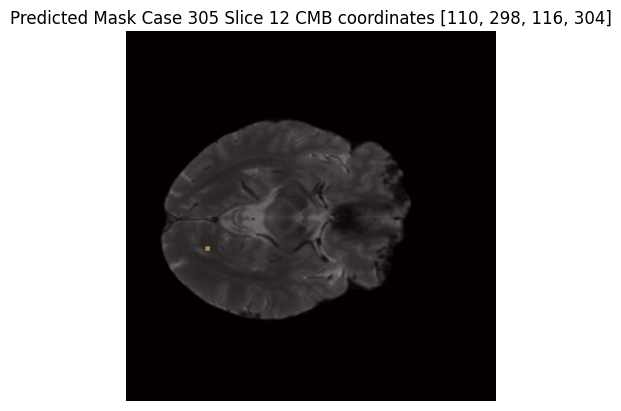

================Case 305 Slice 13================
Slice 13
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 14================
Slice 14
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 15================
Slice 15
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 16================
Slice 16
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 17================
Slice 17
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 305 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 3

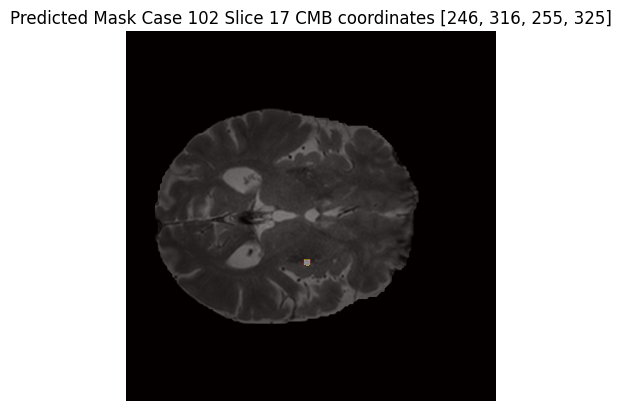

================Case 102 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 19================
Slice 19
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 20================
Slice 20
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 21================
Slice 21
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 22================
Slice 22
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 102 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 1

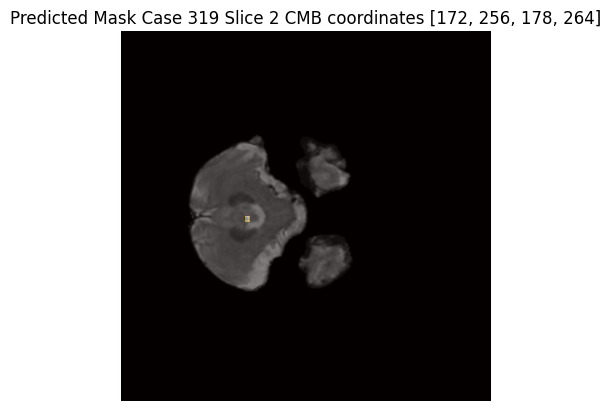

================Case 319 Slice 3================
Slice 3
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 4================
Slice 4
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 5================
Slice 5
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 6================
Slice 6
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 7================
Slice 7
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 8================
Slice 8
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 319 Slice 9==

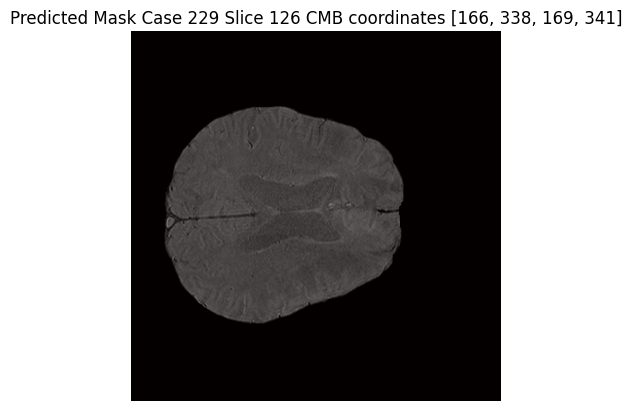

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 338, 169, 341]


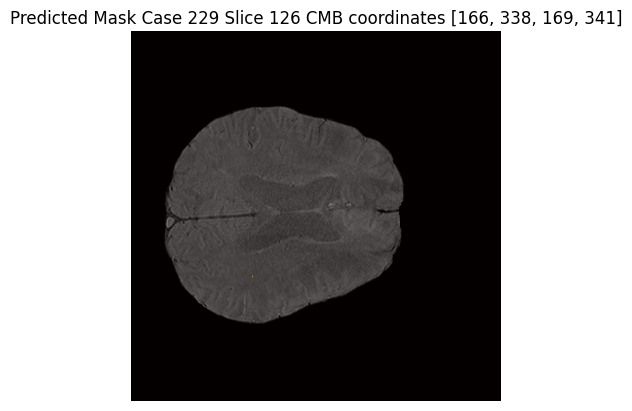

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 338, 169, 341]


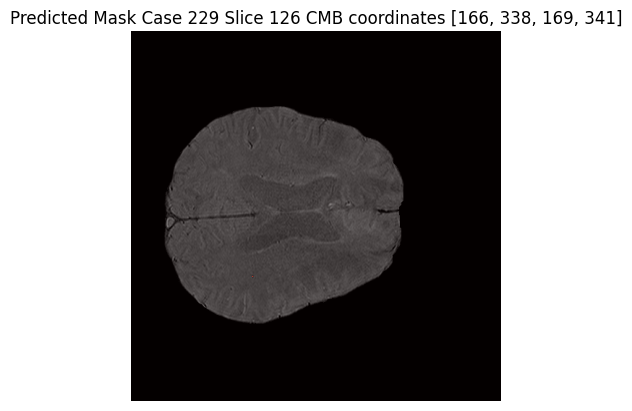

================Case 229 Slice 127================
Slice 127
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [167, 338, 169, 341]


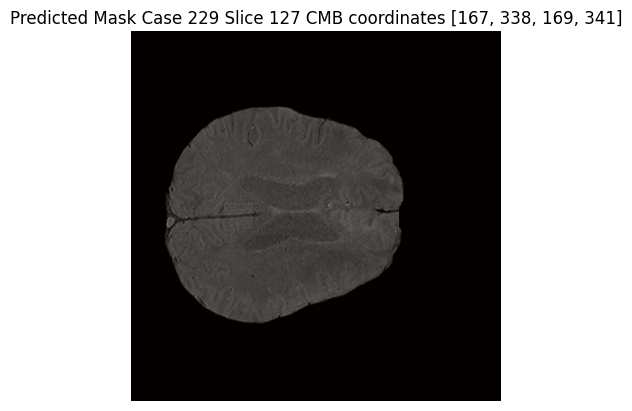

================Case 229 Slice 128================
Slice 128
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [167, 338, 169, 341]


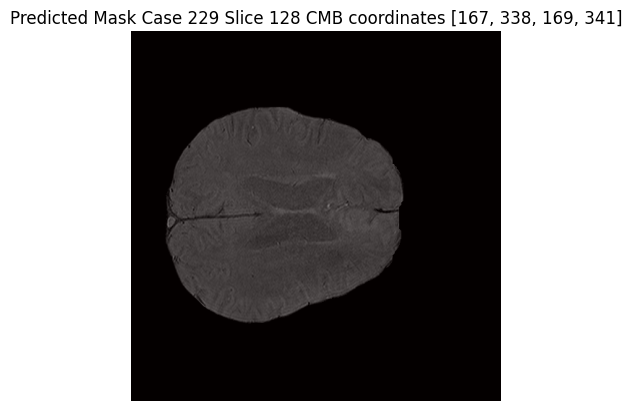

================Case 229 Slice 129================
Slice 129
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 130================
Slice 130
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 131================
Slice 131
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 132================
Slice 132
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 133================
Slice 133
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 229 Slice 134================
Slice 134
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
==========

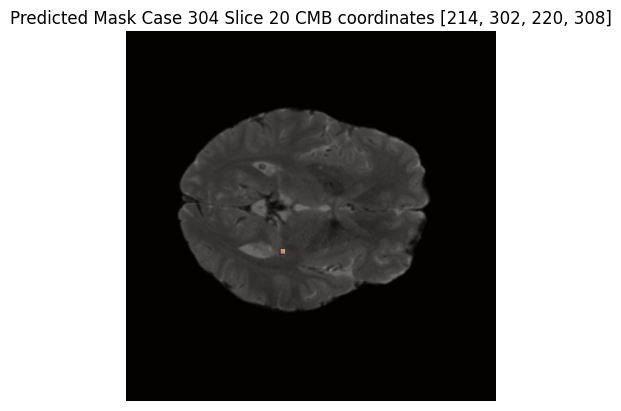

================Case 304 Slice 21================
Slice 21
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 22================
Slice 22
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 304 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 3

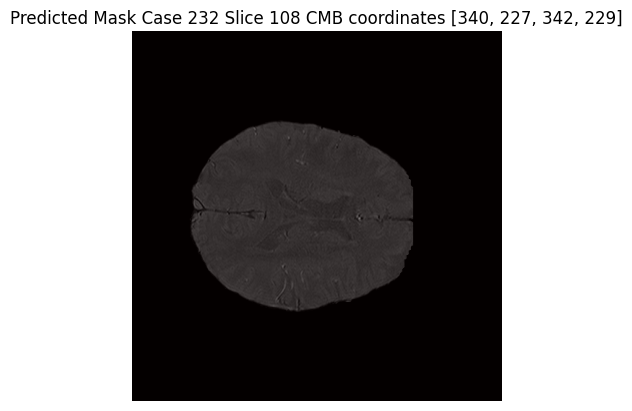

================Case 232 Slice 109================
Slice 109
Image shape:  torch.Size([1, 512, 512])
Prediction length:  4
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


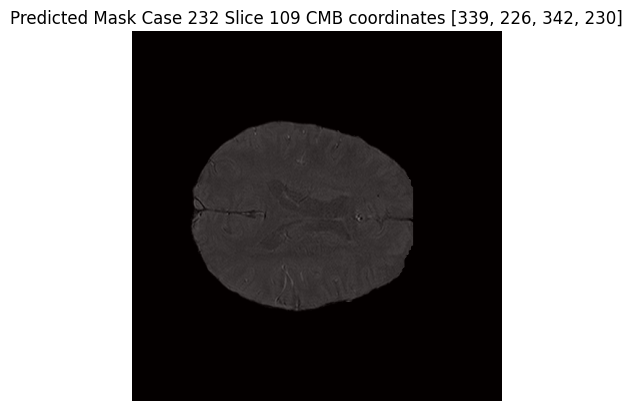

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


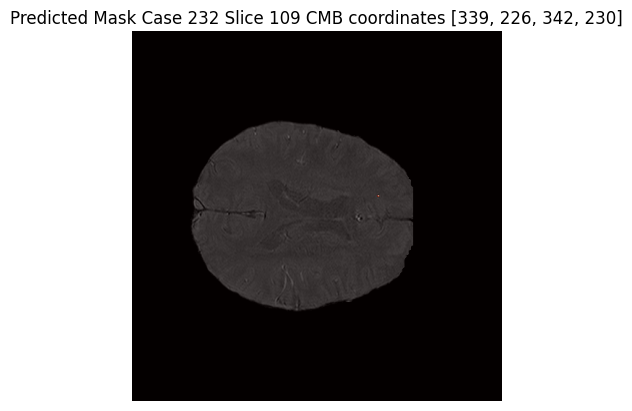

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


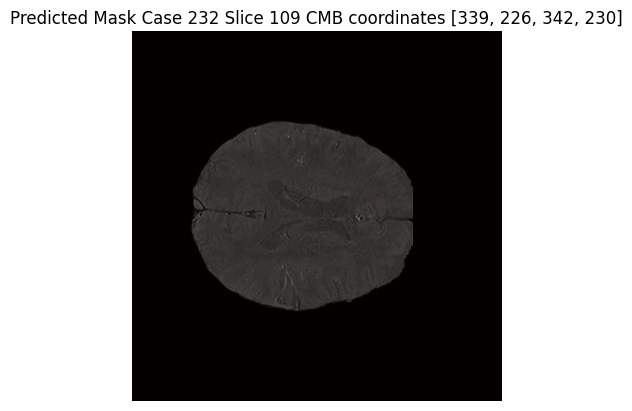

Prediction 3
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


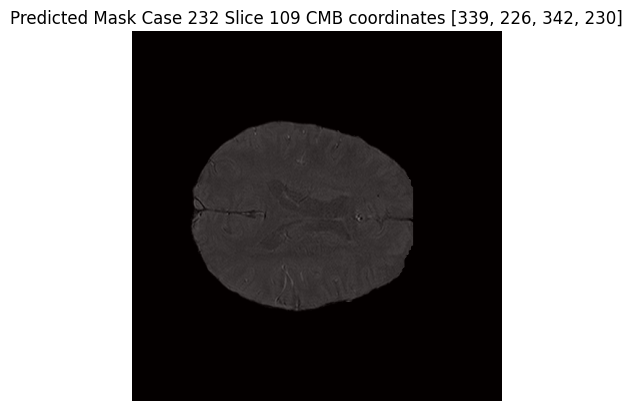

================Case 232 Slice 110================
Slice 110
Image shape:  torch.Size([1, 512, 512])
Prediction length:  4
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


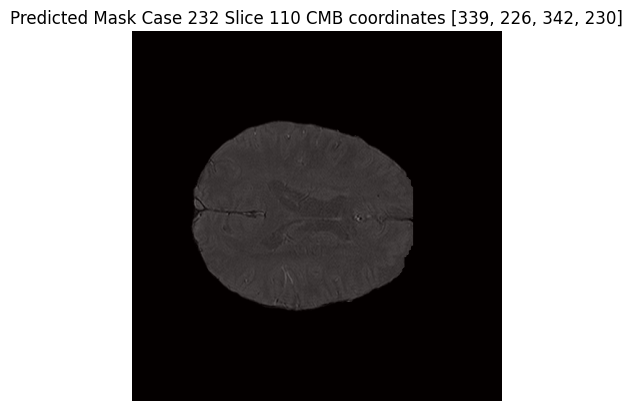

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


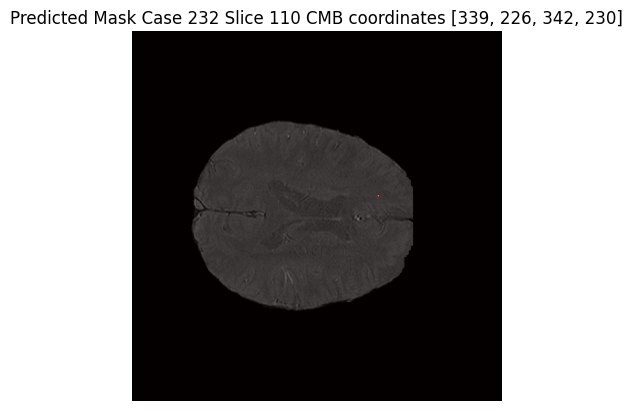

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


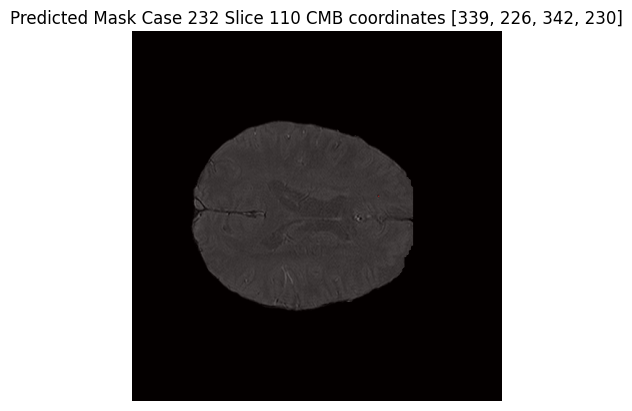

Prediction 3
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 226, 342, 230]


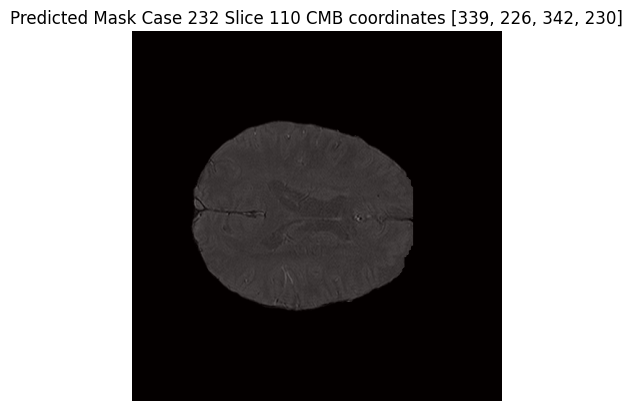

================Case 232 Slice 111================
Slice 111
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [339, 227, 341, 229]


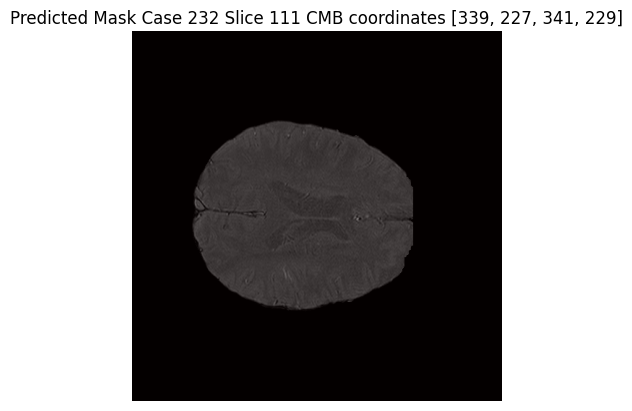

================Case 232 Slice 112================
Slice 112
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 113================
Slice 113
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 114================
Slice 114
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 115================
Slice 115
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 116================
Slice 116
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 232 Slice 117================
Slice 117
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
==========

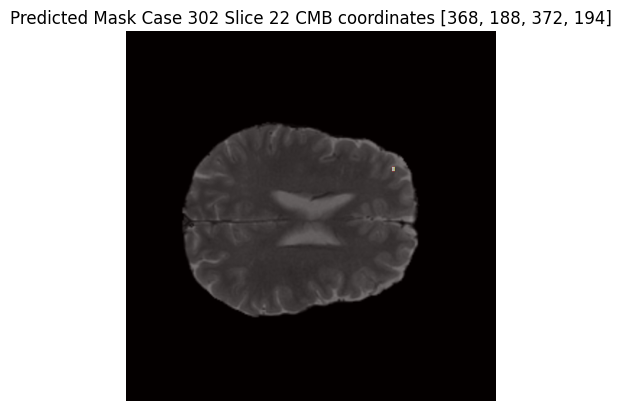

================Case 302 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  3
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 374, 194]


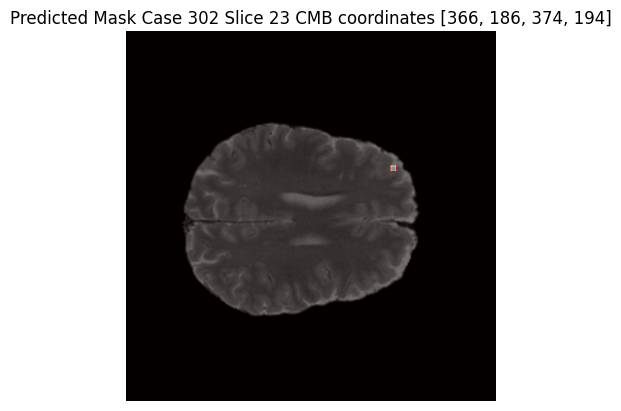

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 374, 194]


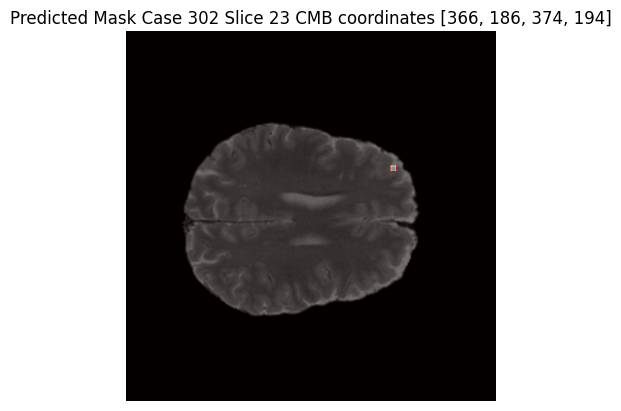

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 374, 194]


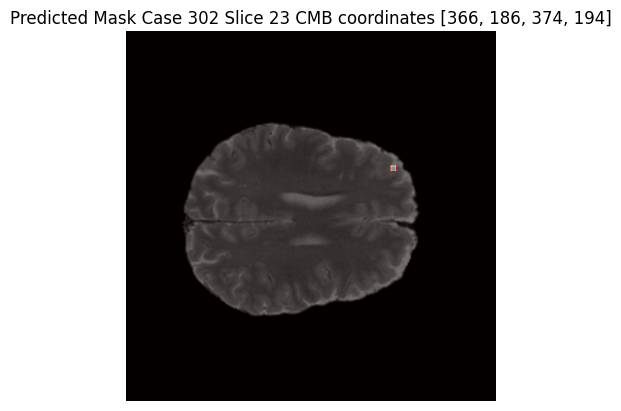

================Case 302 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  3
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 372, 192]


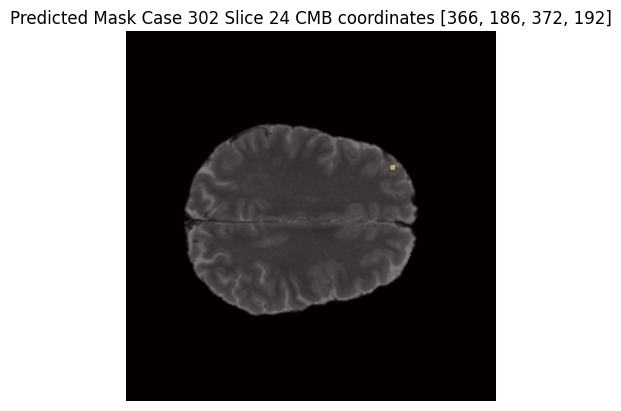

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 372, 192]


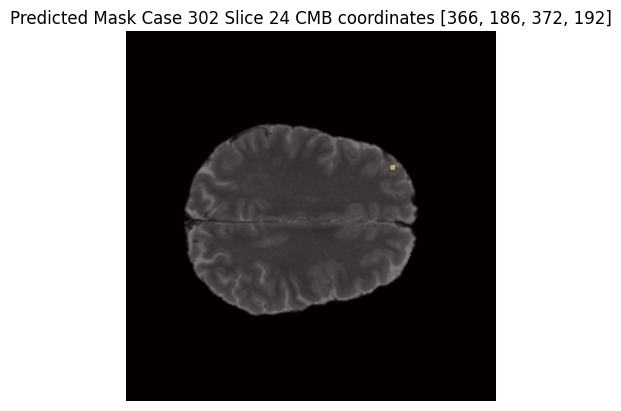

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [366, 186, 372, 192]


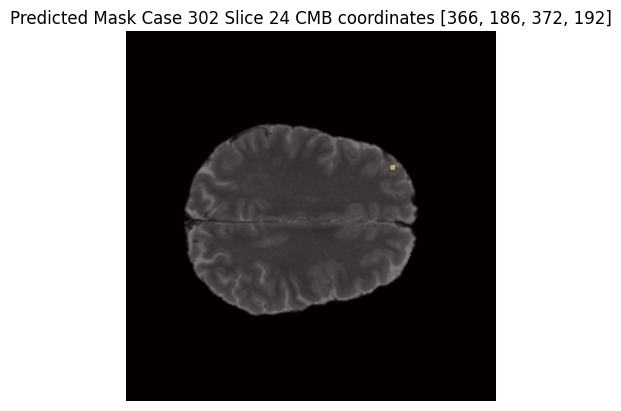

================Case 302 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 27================
Slice 27
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 28================
Slice 28
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 29================
Slice 29
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 302 Slice 30================
Slice 30
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 3

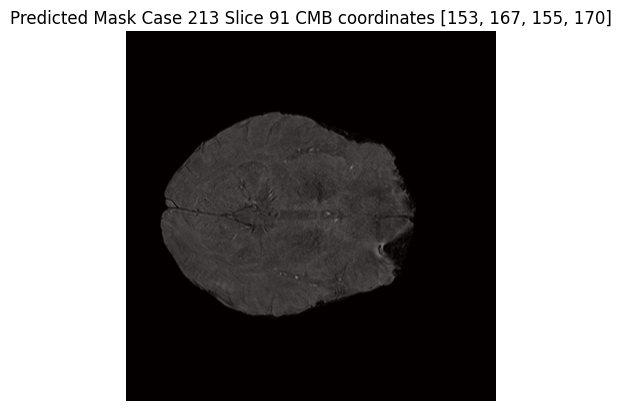

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 167, 155, 170]


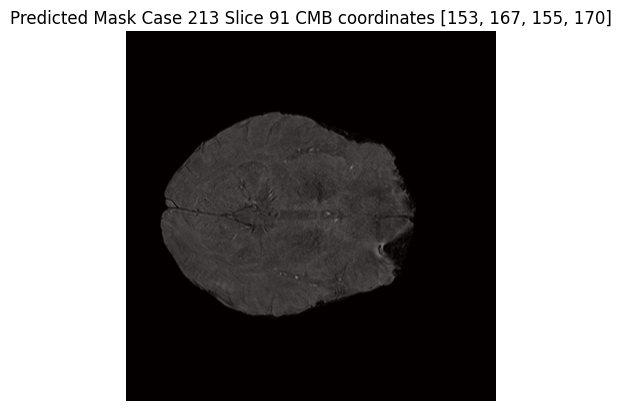

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 167, 155, 170]


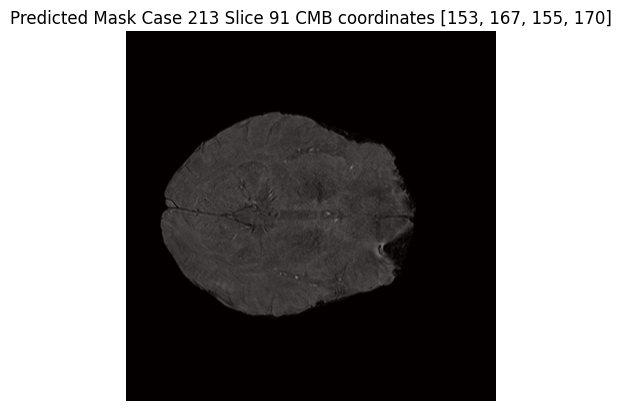

================Case 213 Slice 92================
Slice 92
Image shape:  torch.Size([1, 512, 512])
Prediction length:  3
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 155, 171]


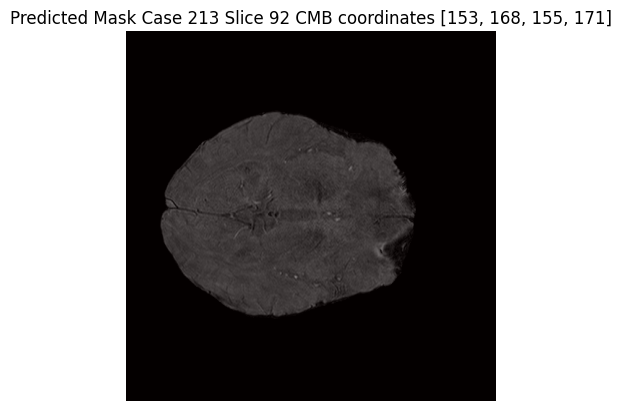

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 155, 171]


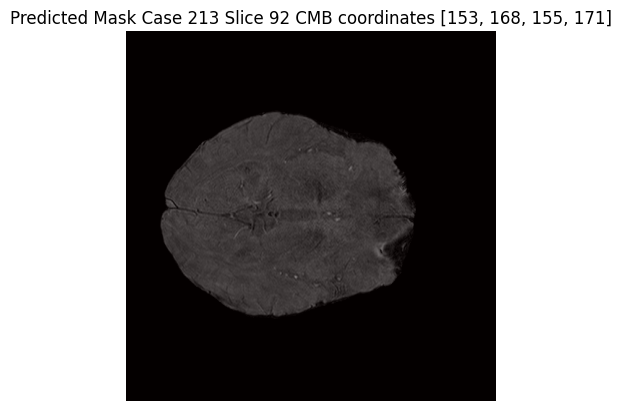

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 155, 171]


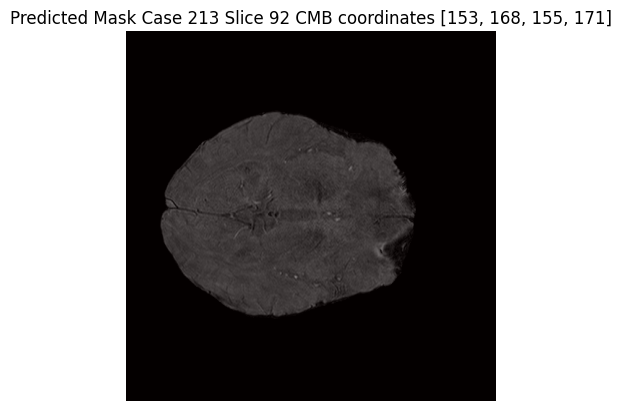

================Case 213 Slice 93================
Slice 93
Image shape:  torch.Size([1, 512, 512])
Prediction length:  3
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 156, 172]


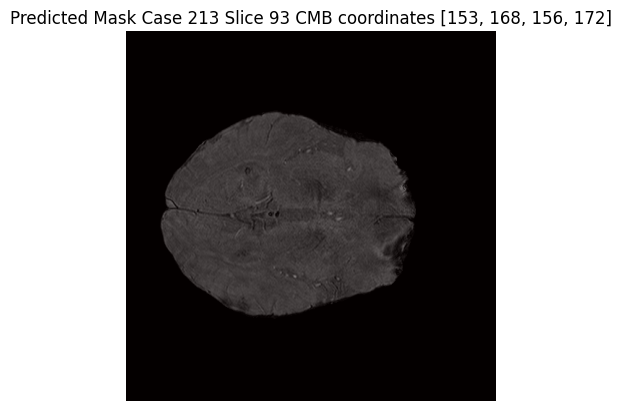

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 156, 172]


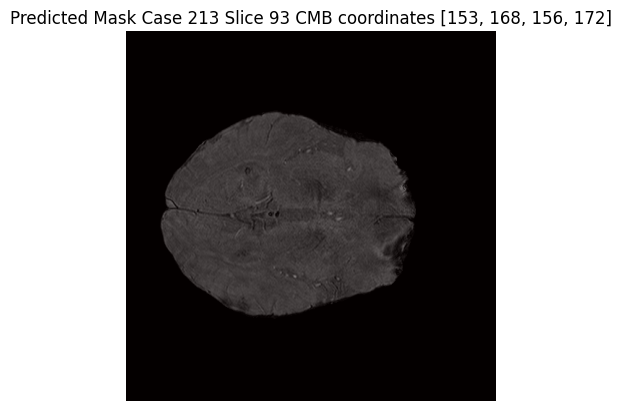

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [153, 168, 156, 172]


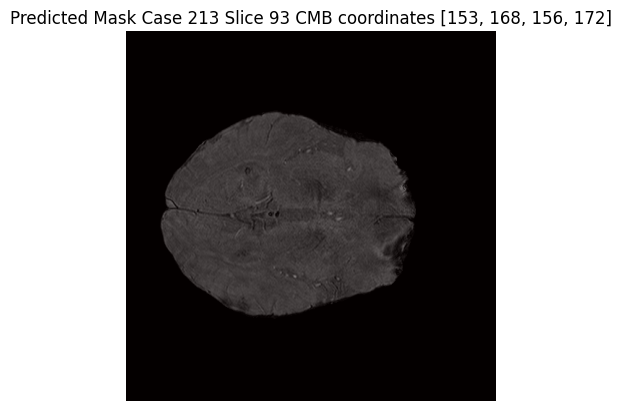

================Case 213 Slice 94================
Slice 94
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 95================
Slice 95
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 96================
Slice 96
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 97================
Slice 97
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 98================
Slice 98
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 213 Slice 99================
Slice 99
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 2

In [37]:
for case in predictions:
    case_number = case[0]
    print(f"------------Case {case_number}---------------")
    print("Length of the whole case: ", len(case))
    print("Case number", case[0])
    print("Number of slices: ", len(case[1]))

    for i, case_slice in enumerate(case[1]):
        slice_number = case_slice[0]
        print(f"================Case {case_number} Slice {slice_number}================")
        print(f"Slice {slice_number}")
        print("Image shape: ", case_slice[1].shape)
        print("Prediction length: ", len(case_slice[2]))
        print("True label shape: ", case_slice[3].shape)
        slice_image = case_slice[1][0]
        slice_prediction = case_slice[2]
        # Assuming your slice_prediction contains multiple masks
        for j, slice_pred in enumerate(slice_prediction):
            print(f"Prediction {j}")
            print("Predicted Mask shape: ", slice_pred[0].shape)
            print("True Mask shape: ", slice_pred[1].shape)
            print("Coordinates: ", slice_pred[2])
            
            predicted_mask = slice_pred[0]  
            true_mask = slice_pred[1]       
            coordinates = slice_pred[2]     
            

            predicted_mask = torch.tensor(predicted_mask, dtype=torch.float32)
            
   
            image_slice = slice_image
            
            
            if mask_type == 'p':
                image, mask_overlay = overlay_mask(image_slice, predicted_mask, coordinates)
                show_image(image, mask_overlay, f'Predicted Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            elif mask_type == 't':
                image, mask_overlay = overlay_mask(image_slice, true_mask, coordinates)
                show_image(image, mask_overlay, f'True Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            else:
                print("Invalid input! Skipping this slice.")
    # break

#### Whole process is completed

In [38]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
